In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_parquet('../sampling/data/combined_dataset.parquet')

In [3]:
df.columns

Index(['id', 'message_id', 'campaign_id', 'message_type', 'client_id',
       'channel_x', 'category', 'platform', 'email_provider', 'stream', 'date',
       'sent_at', 'is_opened', 'opened_first_time_at', 'opened_last_time_at',
       'is_clicked', 'clicked_first_time_at', 'clicked_last_time_at',
       'is_unsubscribed', 'unsubscribed_at', 'is_hard_bounced',
       'hard_bounced_at', 'is_soft_bounced', 'soft_bounced_at',
       'is_complained', 'complained_at', 'is_blocked', 'blocked_at',
       'is_purchased', 'purchased_at', 'created_at', 'updated_at',
       'campaign_type', 'channel_y', 'topic', 'started_at', 'finished_at',
       'total_count', 'ab_test', 'warmup_mode', 'hour_limit', 'subject_length',
       'subject_with_personalization', 'subject_with_deadline',
       'subject_with_emoji', 'subject_with_bonuses', 'subject_with_discount',
       'subject_with_saleout', 'is_test', 'position', 'first_purchase_date'],
      dtype='object')

In [4]:
df = df.drop(columns=['category'])
df = df.dropna(subset=['sent_at', 'date'])

In [5]:
# Ensure datetime columns are in datetime format
time_cols = [
    'sent_at', 'opened_first_time_at', 'opened_last_time_at',
    'clicked_first_time_at', 'clicked_last_time_at', 'purchased_at'
]
for col in time_cols:
    df[col] = pd.to_datetime(df[col])

# Sort messages by client_id and sent time
df = df.sort_values(['client_id', 'sent_at'])

In [6]:
print(f"Number of instances with not clicked but purchased: {df[(df['is_clicked'] == 0) & (df['is_purchased'] == 1)].shape[0]}")
print(f"Number of instances with not opened but purchased: {df[(df['is_opened'] == 0) & (df['is_purchased'] == 1)].shape[0]}")
print(f"Number of instances with not opened but clicked: {df[(df['is_opened'] == 0) & (df['is_clicked'] == 1)].shape[0]}")

Number of instances with not clicked but purchased: 0
Number of instances with not opened but purchased: 56
Number of instances with not opened but clicked: 1992


We can assume that clients couldn't buy the products without messages, maybe in a few cases message was not opened, but the link was clicked, but it seems like a technical issue of tracking. The results above seem like the only way of buying products was the campaign messages.

In [7]:
df.head()

,id,message_id,campaign_id,message_type,client_id,channel_x,platform,email_provider,stream,date,...,subject_length,subject_with_personalization,subject_with_deadline,subject_with_emoji,subject_with_bonuses,subject_with_discount,subject_with_saleout,is_test,position,first_purchase_date
1016209,103564988,1515915625468061251-2003-619de493a8526,2003,bulk,1515915625468061251,email,None,yandex.ru,desktop,2021-11-24,...,126.0,False,False,True,False,False,False,None,NaN,2023-09-18
1146046,133120616,1515915625468061251-2499-61d2a08fbba35,2499,bulk,1515915625468061251,email,None,yandex.ru,desktop,2022-01-03,...,108.0,False,False,True,False,False,False,None,NaN,2023-09-18
651141,142452323,1515915625468061251-2575-61de8184cc1a5,2575,bulk,1515915625468061251,email,None,yandex.ru,desktop,2022-01-12,...,106.0,False,False,True,False,False,False,None,NaN,2023-09-18
531896,149450678,1515915625468061251-2716-61ea9d434e659,2716,bulk,1515915625468061251,email,None,yandex.ru,desktop,2022-01-21,...,98.0,False,False,True,False,False,False,None,NaN,2023-09-18
533530,156887687,1515915625468061251-2795-61f39500008da,2795,bulk,1515915625468061251,email,None,yandex.ru,desktop,2022-01-28,...,118.0,False,False,True,False,False,False,None,NaN,2023-09-18


In [8]:
import sys
sys.path.append('..')
sys.path.append('../src')

import src.feature_engineering as feat_eng
from src import data_loading as loader
from src import preprocess_for_fe as preprocessor

In [9]:
df = loader.load_data('../sampling/data/combined_dataset.parquet')

Loading data from ../sampling/data/combined_dataset.parquet...
✅ Loaded 1,686,884 rows, 51 columns
   Date range: 2021-04-30 05:00:38 to 2023-04-23 23:59:11


In [ ]:
import sys
sys.path.append('..')
sys.path.append('../src')

import src.feature_engineering as feat_eng
from src import data_loading as loader
from src import preprocess_for_fe as preprocessor

df = loader.load_data('../sampling/data/combined_dataset.parquet')
df = preprocessor.prepare_data(df)
df = preprocessor.clean_data(df)
df = feat_eng.engineer_all_features(df)

DATA PREPARATION
Initial shape: (1686884, 51)
Removed 419 rows with invalid sent_at
Removed 6,417 duplicate timestamps
Final shape: (1680048, 51)
Date range: 2021-04-30 05:00:38 to 2023-04-23 23:59:11
Unique clients: 39,983
Unique campaigns: 1,544

Performing data cleaning...
✅ Data cleaning complete



In [11]:
df = feat_eng.engineer_all_features(df)


FEATURE ENGINEERING PIPELINE
Input shape: (1680048, 53)

Creating temporal features...
  ✅ Created 16 temporal features
Creating rolling features...
  ✅ Created 56 rolling features
Creating market-level features...


/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/nd_notebooks/../src/features/market_features.py:32: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df.groupby(pd.Grouper(key='sent_at', freq='1H'))
/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/nd_notebooks/../src/features/market_features.py:41: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .rolling(lookback, closed='left')


  ✅ Created 5 market-level features

ENGAGEMENT FEATURE ENGINEERING
Found 3 engagement metrics: is_opened, is_clicked, is_purchased

  Creating lagged engagement features...
    ✅ Created 5 lagged features
  Creating rolling engagement rates...
    ✅ Created 6 rolling rate features
  Creating Bayesian smoothed rates...
    Global is_opened rate: 0.1799
    Global is_clicked rate: 0.0084
    Global is_purchased rate: 0.0002
    ✅ Created 3 smoothed rate features
  Creating campaign quality features...
    ✅ Created 6 campaign quality features
  Creating expectation gap features...
    ✅ Created 9 expectation gap features

------------------------------------------------------------
SUMMARY: Created 29 engagement features
  • Lagged: 8
  • Rolling rates: 6
  • Smoothed rates: 3
  • Campaign quality: 6
  • Expectation gaps: 9



/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/nd_notebooks/../src/features/global_campaign_performance_features.py:23: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')


✅ Added global campaign performance trend features:
  - global_is_opened_rate_1d, global_is_opened_rate_1w, global_is_opened_rate_1m, global_is_clicked_rate_1d, global_is_clicked_rate_1w, global_is_clicked_rate_1m, global_is_purchased_rate_1d, global_is_purchased_rate_1w, global_is_purchased_rate_1m


/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/nd_notebooks/../src/features/clients_expectation_deviation_features.py:42: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


✅ Added client vs. global engagement deviation features:
   - open_gap_1d, open_gap_1w, open_gap_1m, click_gap_1d, click_gap_1w, click_gap_1m, purchase_gap_1d, purchase_gap_1w, purchase_gap_1m
Computing spam/delivery health features...

Final shape: (1562021, 202)
Total features created: 182



In [14]:
df['message_type'].value_counts(dropna=False)

message_type
bulk    1562021
Name: count, dtype: int64

In [16]:
df.channel_x.value_counts(dropna=False)

channel_x
email          971428
mobile_push    590593
Name: count, dtype: int64

In [15]:
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

is_test                          1.0
position                         1.0
days_since_last_transactional    1.0
days_since_last_trigger          1.0
days_since_last_push             1.0
                                ... 
month                            0.0
day_of_month                     0.0
weekday                          0.0
hour                             0.0
spam_risk_index_1m               0.0
Length: 202, dtype: float64

# EDA

In [17]:
df['is_opened_rate_1m'].value_counts(dropna=False)

is_opened_rate_1m
0.000000    921739
NaN         102004
1.000000    101070
0.500000     27912
0.166667     25333
             ...  
0.305556         1
0.678571         1
0.228571         1
0.655172         1
0.531250         1
Name: count, Length: 304, dtype: int64

In [18]:
df['is_opened'].value_counts(dropna=False)

is_opened
0    1281027
1     280994
Name: count, dtype: int64

In [19]:
df[['is_opened', 'is_opened_rate_1w']].corr()

,is_opened,is_opened_rate_1w
is_opened,1.000000,0.676804
is_opened_rate_1w,0.676804,1.000000


<Axes: >

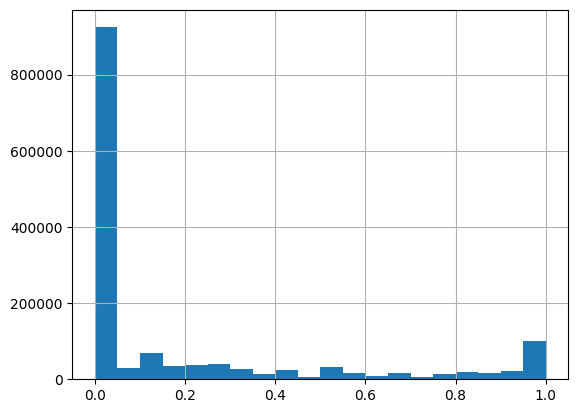

In [20]:
df['is_opened_rate_1m'].hist(bins=20)

<Axes: >

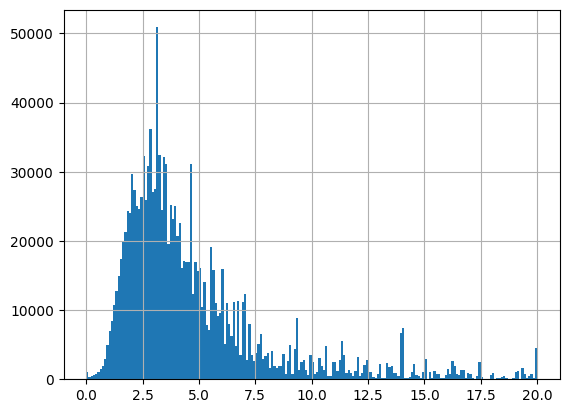

In [21]:
df[df['avg_interval_1m']<20]['avg_interval_1m'].hist(bins=200)

In [22]:
df['avg_interval_1m'].median()

np.float64(3.9766579861111113)

Total numeric/boolean features: 164
Target variables: ['is_opened', 'is_clicked', 'is_purchased']

Top 10 correlations with is_opened:
is_opened_rate_1m                     0.705202
is_opened_rate_1w                     0.676804
is_opened_rate_prev_smooth            0.651280
is_opened_rate_campaign_per_client    0.647511
open_deviation_1m                     0.414743
is_opened_expect_gap_1m               0.383181
is_opened_rate_campaign               0.364960
is_opened_expect_gap_1w               0.322882
open_deviation_1w                     0.319453
is_email                              0.237996
Name: is_opened, dtype: float64

Top 10 correlations with is_clicked:
is_clicked_rate_prev_smooth            0.196894
is_clicked_rate_campaign_per_client    0.168135
is_clicked_rate_1m                     0.159863
click_deviation_1m                     0.142720
is_opened_rate_campaign_per_client     0.118171
is_clicked_rate_1w                     0.110303
click_deviation_1w                   

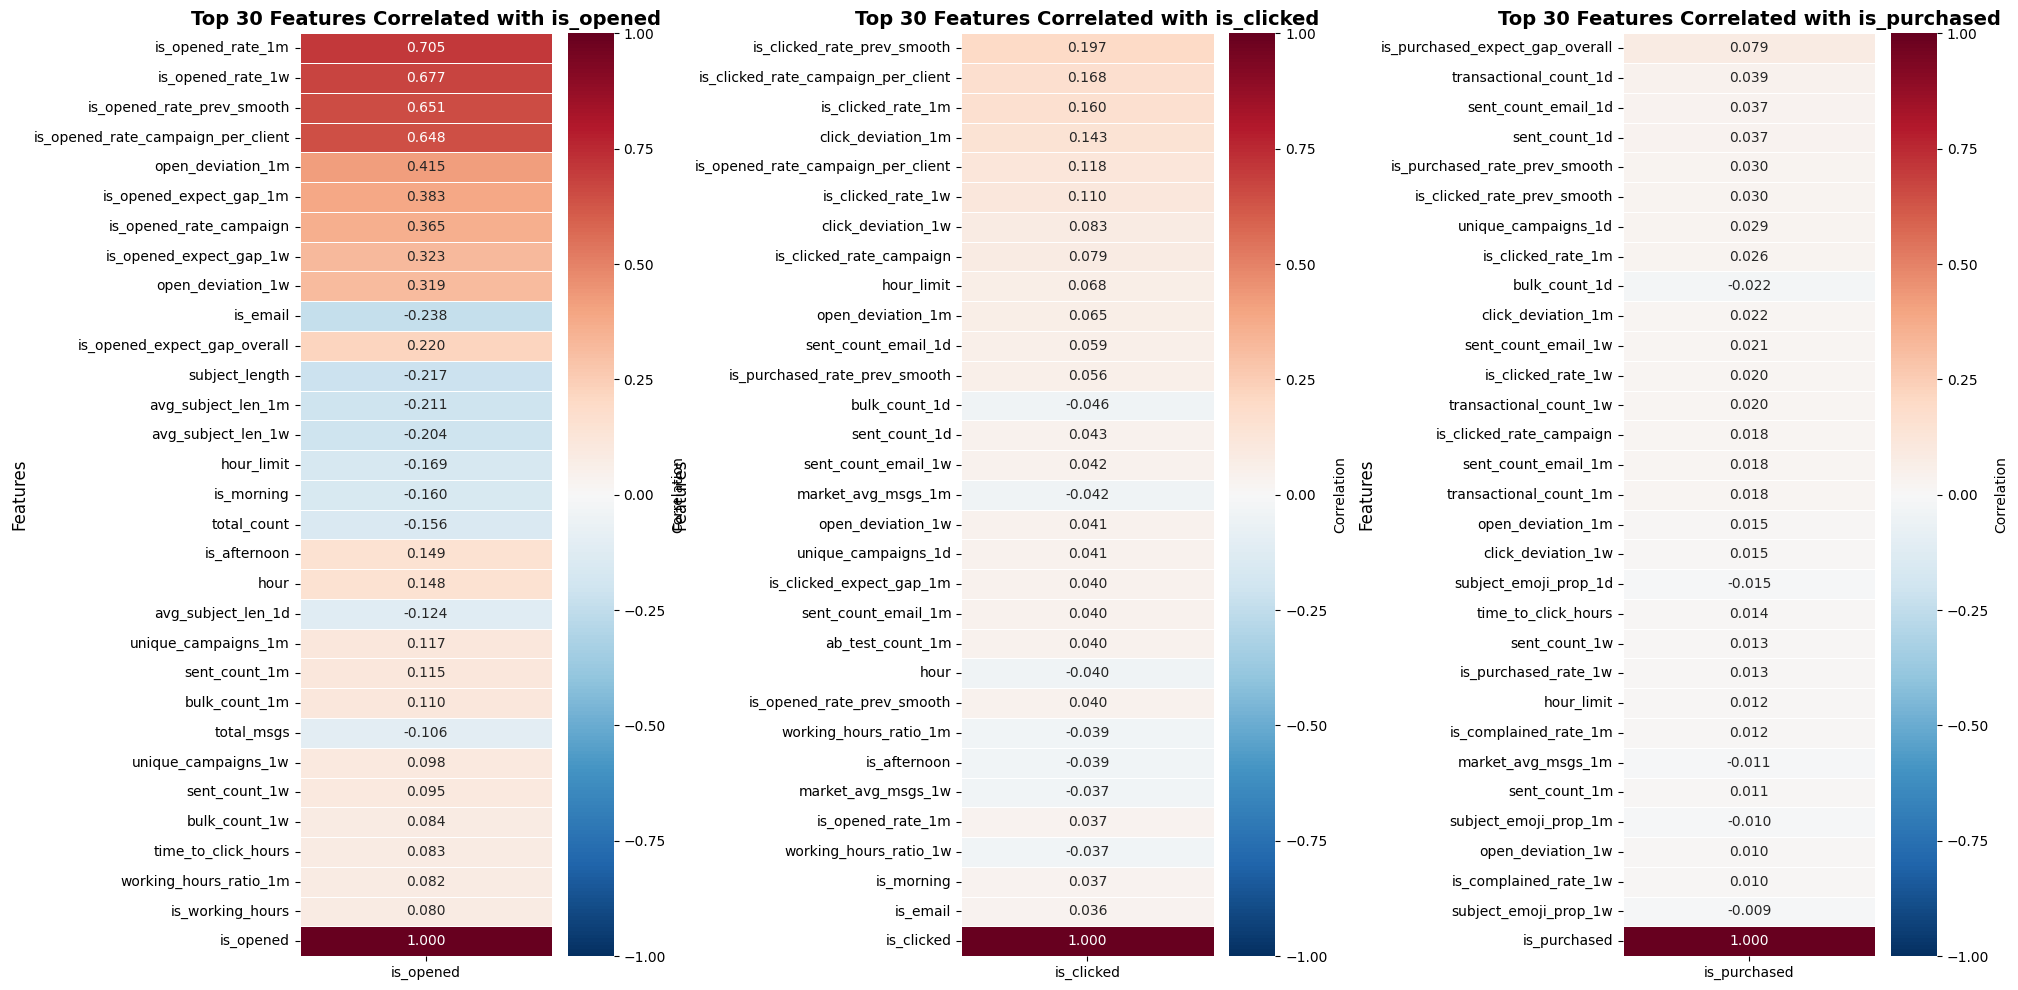

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_engagement_correlation_heatmaps(df, top_n=30):
    """
    Plot correlation heatmaps showing relationships between features and engagement metrics.
    
    Parameters:
    -----------
    df : DataFrame
        Your dataframe with all features
    top_n : int
        Number of top correlated features to show for each target
    """
    
    # Target variables
    targets = ['is_opened', 'is_clicked', 'is_purchased']
    
    # Get numeric and boolean columns
    numeric_cols = df.select_dtypes(include=[np.number, 'bool']).columns.tolist()
    
    # Remove target variables from feature list
    feature_cols = [col for col in numeric_cols if col not in targets]
    
    # Remove ID columns and other non-predictive columns
    exclude_patterns = ['id', 'message_id', 'campaign_id', 'client_id']
    feature_cols = [col for col in feature_cols if not any(pattern in col.lower() for pattern in exclude_patterns)]
    
    print(f"Total numeric/boolean features: {len(feature_cols)}")
    print(f"Target variables: {targets}")
    
    # Compute correlations
    correlation_data = {}
    
    for target in targets:
        if target in df.columns:
            # Compute correlation with all features
            correlations = df[feature_cols + [target]].corr()[target].drop(target)
            
            # Sort by absolute correlation
            correlations_sorted = correlations.abs().sort_values(ascending=False)
            
            correlation_data[target] = correlations[correlations_sorted.index]
            
            print(f"\nTop 10 correlations with {target}:")
            print(correlations_sorted.head(10))
    
    # ========================================
    # Plot 1: Separate heatmap for each target (top N features)
    # ========================================
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    for idx, target in enumerate(targets):
        if target not in correlation_data:
            continue
        
        # Get top N features by absolute correlation
        top_features = correlation_data[target].abs().nlargest(top_n)
        
        # Create correlation matrix for these features + target
        selected_features = top_features.index.tolist() + [target]
        corr_matrix = df[selected_features].corr()
        
        # Plot heatmap
        sns.heatmap(
            corr_matrix[[target]],  # Only show correlation with target
            annot=True,
            fmt='.3f',
            cmap='RdBu_r',
            center=0,
            vmin=-1,
            vmax=1,
            cbar_kws={'label': 'Correlation'},
            ax=axes[idx],
            linewidths=0.5
        )
        
        axes[idx].set_title(f'Top {top_n} Features Correlated with {target}', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('')
        axes[idx].set_ylabel('Features', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('correlation_heatmap_separate.png', dpi=300, bbox_inches='tight')
    print("\n✅ Saved: correlation_heatmap_separate.png")
    plt.show()
 

plot_engagement_correlation_heatmaps(df, top_n=30)

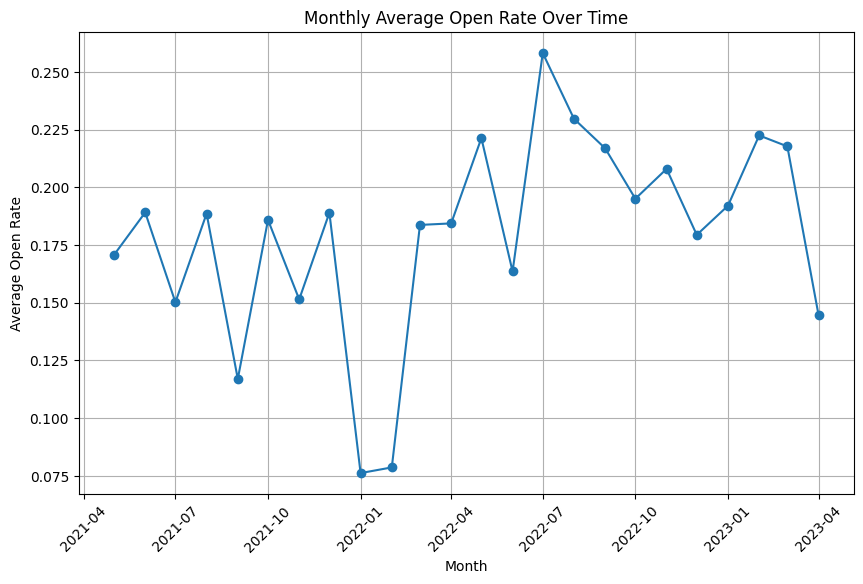

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure sent_at is datetime
df['sent_at'] = pd.to_datetime(df['sent_at'])

# --- Step 1: Extract month (year-month) ---
df['month'] = df['sent_at'].dt.to_period('M')

# --- Step 2: Group by month and calculate average open rate ---
monthly_avg = df.groupby('month')['is_opened_rate_1m'].mean().reset_index()

# Convert month back to timestamp for plotting
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()

# --- Step 3: Plot line chart ---
plt.figure(figsize=(10,6))
plt.plot(monthly_avg['month'], monthly_avg['is_opened_rate_1m'], marker='o', linestyle='-')

plt.xlabel("Month")
plt.ylabel("Average Open Rate")
plt.title("Monthly Average Open Rate Over Time")
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

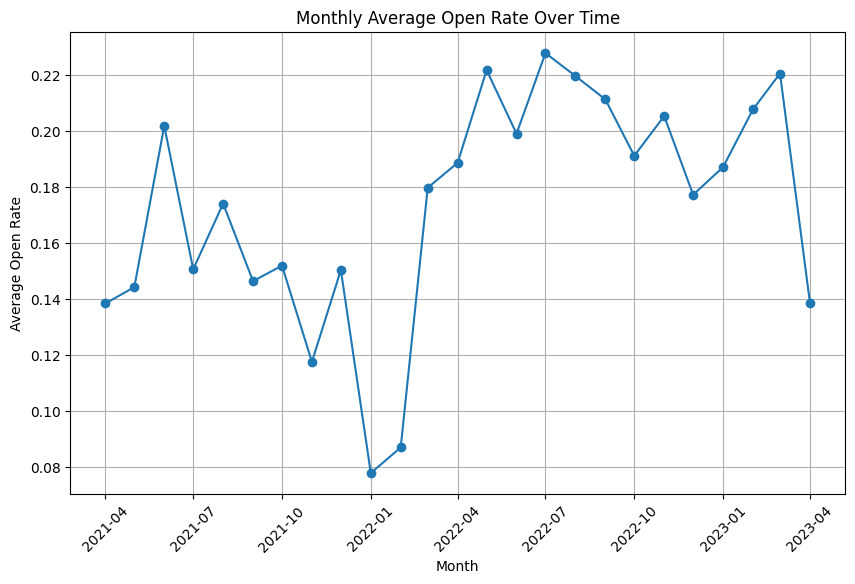

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure sent_at is datetime
df['sent_at'] = pd.to_datetime(df['sent_at'])

# --- Step 1: Extract month (year-month) ---
df['month'] = df['sent_at'].dt.to_period('M')

# --- Step 2: Group by month and calculate average open rate ---
monthly_avg = df.groupby('month')['is_opened'].mean().reset_index()

# Convert month back to timestamp for plotting
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()

# --- Step 3: Plot line chart ---
plt.figure(figsize=(10,6))
plt.plot(monthly_avg['month'], monthly_avg['is_opened'], marker='o', linestyle='-')

plt.xlabel("Month")
plt.ylabel("Average Open Rate")
plt.title("Monthly Average Open Rate Over Time")
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

/var/folders/bg/38ht234d5p50ytp9mrxf80nc0000gn/T/ipykernel_76482/134838510.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sent_at'] = pd.to_datetime(df['sent_at'])
/var/folders/bg/38ht234d5p50ytp9mrxf80nc0000gn/T/ipykernel_76482/134838510.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['sent_at'].dt.to_period('M')


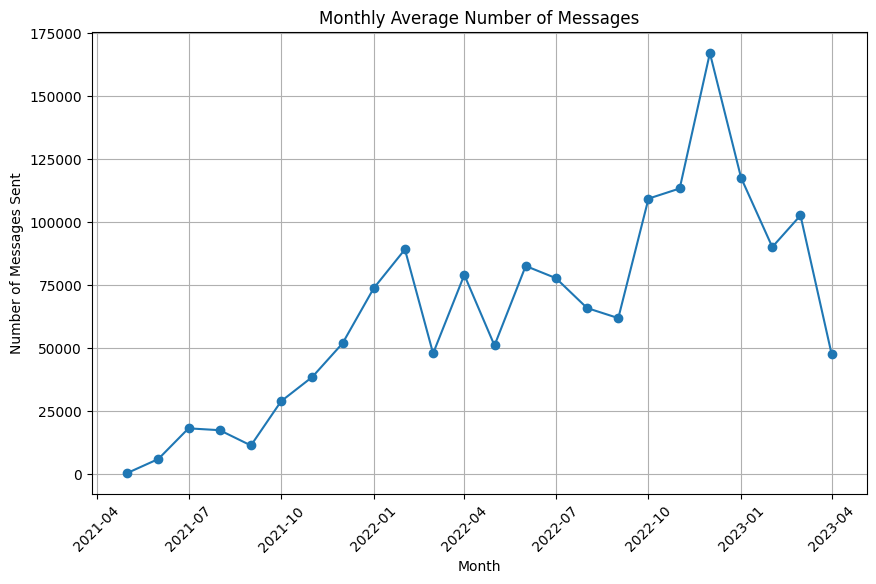

In [313]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure sent_at is datetime
df['sent_at'] = pd.to_datetime(df['sent_at'])

# --- Step 1: Extract month (year-month) ---
df['month'] = df['sent_at'].dt.to_period('M')

# --- Step 2: Group by month and calculate average open rate ---
monthly_avg = df.groupby('month')['id'].count().reset_index()

# Convert month back to timestamp for plotting
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()

# --- Step 3: Plot line chart ---
plt.figure(figsize=(10,6))
plt.plot(monthly_avg['month'], monthly_avg['id'], marker='o', linestyle='-')

plt.xlabel("Month")
plt.ylabel("Number of Messages Sent")
plt.title("Monthly Average Number of Messages")
plt.grid(True)
plt.xticks(rotation=45)

plt.show()

<Axes: >

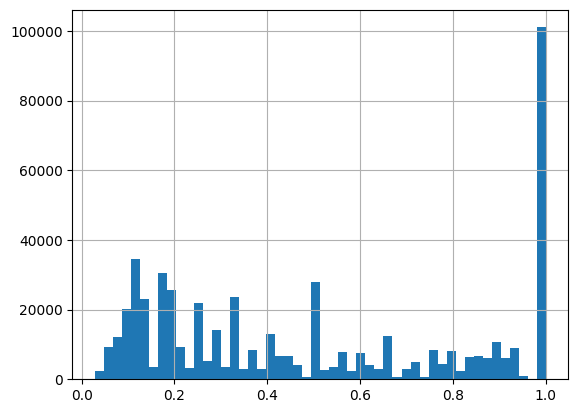

In [27]:
df[df['is_opened_rate_1m'] != 0]['is_opened_rate_1m'].hist(bins=50)

<Axes: >

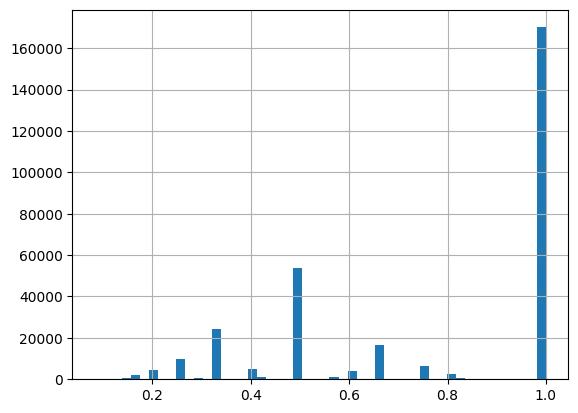

In [28]:
df[df['is_opened_rate_1w'] != 0]['is_opened_rate_1w'].hist(bins=50)

In [65]:
df['sent_count_1m'].value_counts(dropna=False).sort_values()

sent_count_1m
191.0         1
192.0         1
189.0         1
190.0         1
173.0         2
          ...  
8.0      125569
9.0      127852
5.0      130374
7.0      131615
6.0      136617
Name: count, Length: 201, dtype: int64

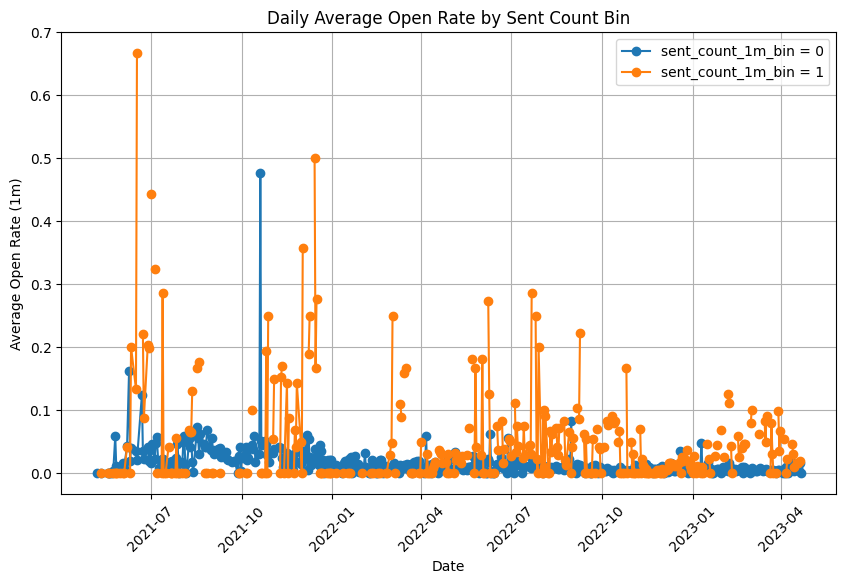

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create the bin column
df['sent_count_1m_bin'] = np.where(df['sent_count_1m'] > 50, 1, 0)

# Ensure datetime
df['sent_at'] = pd.to_datetime(df['sent_at'])
df['date'] = df['sent_at'].dt.date   # make sure you have a date column

# Group by date and bin, then calculate average open rate
daily_avg_bin = (
    df[df['message_type']=='bulk'].groupby(['date', 'sent_count_1m_bin'])['is_clicked_rate_1m']
      .mean()
      .reset_index()
)

# Pivot so each bin becomes its own column
pivoted = daily_avg_bin.pivot(index='date', columns='sent_count_1m_bin', values='is_clicked_rate_1m')

# Plot
plt.figure(figsize=(10,6))
plt.plot(pivoted.index, pivoted[0], marker='o', linestyle='-', label='sent_count_1m_bin = 0')
plt.plot(pivoted.index, pivoted[1], marker='o', linestyle='-', label='sent_count_1m_bin = 1')

plt.xlabel("Date")
plt.ylabel("Average Open Rate (1m)")
plt.title("Daily Average Open Rate by Sent Count Bin")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

plt.show()

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Features (X) and target (y)
df_for_model = df[['sent_count_1m',"sent_count_1d", 'total_msgs', 'market_avg_msgs_6h',
                    'market_avg_msgs_1d', 'market_avg_msgs_1w', 'market_avg_msgs_1m',
                'is_opened_rate_1m', 'is_opened_rate_1w', 
                    'is_opened_rate_prev_smooth', 'is_opened']].dropna()

X = df_for_model[['sent_count_1m', "sent_count_1d", 'total_msgs', 'is_opened_rate_1m', 'is_opened_rate_1w',
'market_avg_msgs_6h',
'market_avg_msgs_1d', 'market_avg_msgs_1w', 'market_avg_msgs_1m',
                   'is_opened_rate_prev_smooth']]  # include both features
y = df_for_model['is_opened']   # binary target (0/1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize logistic regression model
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test_scaled)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Probabilities
y_prob = log_reg.predict_proba(X_test_scaled)[:,1]

# Print coefficients with feature names
print("\nIntercept:", log_reg.intercept_)
for feature, coef in zip(X.columns, log_reg.coef_[0]):
    print(f"{feature}: {coef}")

Confusion Matrix:
[[29884  2015]
 [ 4003  7535]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     31899
           1       0.79      0.65      0.71     11538

    accuracy                           0.86     43437
   macro avg       0.84      0.79      0.81     43437
weighted avg       0.86      0.86      0.86     43437


Intercept: [-1.505696]
sent_count_1m: 0.1348073461666647
sent_count_1d: 0.04685824575937496
total_msgs: -0.05859406259045658
is_opened_rate_1m: 1.0795639139974438
is_opened_rate_1w: 0.5857391831375157
market_avg_msgs_6h: 0.3181878854436193
market_avg_msgs_1d: -0.24751859484713787
market_avg_msgs_1w: -0.10825518832854315
market_avg_msgs_1m: 0.05372875929085303
is_opened_rate_prev_smooth: 0.3202584255066104


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


# Features (X) and target (y)
df_for_model = df[['sent_count_1m','sent_count_1w', "sent_count_1d", 'total_msgs', 'market_avg_msgs_6h',
                    'market_avg_msgs_1d', 'market_avg_msgs_1w', 'market_avg_msgs_1m',
                'is_opened_rate_1m', 'is_opened_rate_1w', 
                    'is_opened_rate_prev_smooth', 'is_opened']].dropna()

df_for_model = df_for_model[df_for_model['is_opened_rate_1m'] > 0.05]

X = df_for_model[['sent_count_1m', 'sent_count_1d']]  # include both features
y = df_for_model['is_opened']   # binary target (0/1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize logistic regression model
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test_scaled)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Probabilities
y_prob = log_reg.predict_proba(X_test_scaled)[:,1]

# Print coefficients with feature names
print("\nIntercept:", log_reg.intercept_)
for feature, coef in zip(X.columns, log_reg.coef_[0]):
    print(f"{feature}: {coef}")

Confusion Matrix:
[[7999 3345]
 [7179 3832]]

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.71      0.60     11344
           1       0.53      0.35      0.42     11011

    accuracy                           0.53     22355
   macro avg       0.53      0.53      0.51     22355
weighted avg       0.53      0.53      0.51     22355


Intercept: [-0.04677188]
sent_count_1m: -0.013876932696126122
sent_count_1w: -0.11341877218676091
sent_count_1d: 0.011921854607979641


In [170]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

# --- Step 1: Prepare dataset ---
df_for_model = df[['sent_count_1m', 'sent_count_1w', "sent_count_1d", 'total_msgs', 'market_avg_msgs_6h',
                    'market_avg_msgs_1d', 'market_avg_msgs_1w', 'market_avg_msgs_1m',
                    'is_opened_rate_1m', 'is_opened_rate_1w', 
                    'is_opened_rate_prev_smooth', 'is_opened']].dropna()

# --- Step 2: Collect results in a list ---
results = []

for threshold in [i/100 for i in range(5, 100, 5)]:  # 0.05, 0.10, ..., 0.95
    df_thresh = df_for_model[df_for_model['is_opened_rate_1m'] > threshold]
    
    if df_thresh.empty:
        continue
    
    X = df_thresh[['sent_count_1m', 'sent_count_1w', 'sent_count_1d']]
    y = df_thresh['is_opened']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit logistic regression
    log_reg = LogisticRegression()
    log_reg.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = log_reg.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    # Precision/Recall for class 1 (positive)
    prec_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    # Precision/Recall for class 0 (negative)
    prec_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    rec_0 = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    
    # Append results
    results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision_1': prec_1,
        'Recall_1': rec_1,
        'Precision_0': prec_0,
        'Recall_0': rec_0,
        'Intercept': log_reg.intercept_[0],   
        'Coef_sent_count_1m': log_reg.coef_[0][0],  # first feature
        'Coef_sent_count_1w': log_reg.coef_[0][1],   # second feature
        'Coef_sent_count_1d': log_reg.coef_[0][2]   # third feature
    })

# --- Step 3: Convert to DataFrame ---
results_df = pd.DataFrame(results)

print("\nLogistic Regression Results by Threshold:")
print(results_df)


Logistic Regression Results by Threshold:
    Threshold  Accuracy  Precision_1  Recall_1  Precision_0  Recall_0  \
0        0.05  0.529233     0.533928  0.348016     0.527013  0.705130   
1        0.10  0.536792     0.538142  0.935611     0.519271  0.079712   
2        0.15  0.571033     0.573748  0.979050     0.449239  0.022954   
3        0.20  0.615499     0.618436  0.984760     0.445255  0.019735   
4        0.25  0.653542     0.657291  0.986823     0.395238  0.016462   
5        0.30  0.673951     0.677895  0.988130     0.367816  0.014496   
6        0.35  0.700024     0.702063  0.994225     0.400000  0.009043   
7        0.40  0.730567     0.733004  0.994371     0.347222  0.008199   
8        0.45  0.751257     0.752906  0.996343     0.382979  0.006894   
9        0.50  0.777997     0.779824  0.996478     0.342105  0.006468   
10       0.55  0.793560     0.794967  0.997661     0.157895  0.001702   
11       0.60  0.819979     0.819992  0.999842     0.800000  0.002865   
12      

In [180]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# --- Step 1: Prepare dataset ---
df_for_model = df[['sent_count_1m', 'sent_count_1w', "sent_count_1d", 'total_msgs', 'market_avg_msgs_6h',
                    'market_avg_msgs_1d', 'market_avg_msgs_1w', 'market_avg_msgs_1m',
                    'is_opened_rate_1m', 'is_opened_rate_1w', 
                    'is_opened_rate_prev_smooth', 'is_opened']].dropna()

results = []

for threshold in [i/100 for i in range(5, 100, 5)]:  # 0.05, 0.10, ..., 0.95
    df_thresh = df_for_model[df_for_model['is_opened_rate_1m'] > threshold]
    if df_thresh.empty:
        continue
    
    # --- Adaptive undersampling ---
    df_pos = df_thresh[df_thresh['is_opened'] == 1]
    df_neg = df_thresh[df_thresh['is_opened'] == 0]
    
    if len(df_pos) == 0 or len(df_neg) == 0:
        continue  # skip if only one class present
    
    # Balance classes by undersampling majority
    if len(df_pos) > len(df_neg):
        df_pos_sampled = df_pos.sample(n=len(df_neg), random_state=42, replace=False)
        df_balanced = pd.concat([df_pos_sampled, df_neg])
    else:
        df_neg_sampled = df_neg.sample(n=len(df_pos), random_state=42, replace=False)
        df_balanced = pd.concat([df_pos, df_neg_sampled])
    
    X_bal = df_balanced[['sent_count_1w']]
    y_bal = df_balanced['is_opened']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_bal, y_bal, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit logistic regression
    log_reg = LogisticRegression()
    log_reg.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = log_reg.predict(X_test_scaled)
    y_prob = log_reg.predict_proba(X_test_scaled)[:,1]  # probabilities for ROC-AUC
    
    acc = accuracy_score(y_test, y_pred)
    prec_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    prec_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    rec_0 = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_prob)
    
    # Share of 1s in original (unbalanced) dataset
    num_1s = df_thresh['is_opened'].sum()
    
    results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        # 'Precision_1': prec_1,
        # 'Recall_1': rec_1,
        # 'Precision_0': prec_0,
        # 'Recall_0': rec_0,
        'ROC_AUC': roc_auc,
        'Intercept': log_reg.intercept_[0],   
        'Coef_sent_count_1w': log_reg.coef_[0][0],
        'Number_of_1s': num_1s
    })

results_df = pd.DataFrame(results)
print("\nLogistic Regression Results by Threshold (Balanced Training):")
print(results_df)


Logistic Regression Results by Threshold (Balanced Training):
    Threshold  Accuracy   ROC_AUC  Intercept  Coef_sent_count_1w  Number_of_1s
0        0.05  0.537161  0.547323  -0.006302           -0.127380         54695
1        0.10  0.527510  0.535056  -0.002622           -0.115829         53358
2        0.15  0.545265  0.553541   0.001107           -0.134949         51901
3        0.20  0.553140  0.559972  -0.000352           -0.179141         49848
4        0.25  0.565196  0.575093  -0.000766           -0.213949         47843
5        0.30  0.563145  0.568042  -0.005244           -0.221348         46116
6        0.35  0.559793  0.569994  -0.001041           -0.225061         44077
7        0.40  0.558039  0.566752  -0.006554           -0.230570         41439
8        0.45  0.561541  0.564235  -0.010560           -0.237046         39340
9        0.50  0.573079  0.574623  -0.010141           -0.242025         35583
10       0.55  0.567376  0.569752   0.001204           -0.203141    

In [178]:
df[df['is_opened_rate_1m'] > 0.4][['sent_count_1w', 'is_opened']].corr()

,sent_count_1w,is_opened
sent_count_1w,1.000000,-0.035404
is_opened,-0.035404,1.000000


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score

# --- Step 1: Prepare dataset ---
df_for_model = df[['sent_count_1m',"sent_count_1d", 'total_msgs', 'market_avg_msgs_6h',
                    'market_avg_msgs_1d', 'market_avg_msgs_1w', 'market_avg_msgs_1m',
                    'is_opened_rate_1m', 'is_opened_rate_1w', 
                    'is_opened_rate_prev_smooth', 'is_opened']].dropna()

# --- Step 2: Collect results in a list ---
results = []

for threshold in [i/100 for i in range(5, 100, 5)]:  # 0.05, 0.10, ..., 0.95
    df_thresh = df_for_model[df_for_model['is_opened_rate_1m'] > threshold]
    
    if df_thresh.empty:
        continue
    
    X = df_thresh[['sent_count_1m']]
    y = df_thresh['is_opened']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit logistic regression
    log_reg = LogisticRegression()
    log_reg.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = log_reg.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    # Precision/Recall for class 1 (positive)
    prec_1 = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec_1 = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    
    # Precision/Recall for class 0 (negative)
    prec_0 = precision_score(y_test, y_pred, pos_label=0, zero_division=0)
    rec_0 = recall_score(y_test, y_pred, pos_label=0, zero_division=0)
    
    # Append results
    results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Precision_1': prec_1,
        'Recall_1': rec_1,
        'Precision_0': prec_0,
        'Recall_0': rec_0,
        'Intercept': log_reg.intercept_[0],
        'Coef_sent_count_1m': log_reg.coef_[0][0]
    })

# --- Step 3: Convert to DataFrame ---
results_df = pd.DataFrame(results)

print("\nLogistic Regression Results by Threshold:")
print(results_df)


Logistic Regression Results by Threshold:
    Threshold  Accuracy  Precision_1  Recall_1  Precision_0  Recall_0  \
0        0.05  0.510669     0.505223  0.316229     0.513096  0.699401   
1        0.10  0.533935     0.535177  0.968181     0.498521  0.036252   
2        0.15  0.571642     0.573333  0.988029     0.433790  0.012320   
3        0.20  0.616427     0.618379  0.989072     0.463054  0.015205   
4        0.25  0.653610     0.657163  0.987653     0.389744  0.015073   
5        0.30  0.674244     0.677858  0.989101     0.368750  0.013364   
6        0.35  0.700421     0.702279  0.994451     0.430233  0.009840   
7        0.40  0.730742     0.732886  0.995089     0.338710  0.006888   
8        0.45  0.751067     0.752522  0.996974     0.314286  0.004213   
9        0.50  0.777448     0.779517  0.996196     0.270270  0.004975   
10       0.55  0.793793     0.794946  0.998099     0.133333  0.001134   
11       0.60  0.819979     0.819992  0.999842     0.800000  0.002865   
12      

In [155]:
(df['sent_count_1m'].quantile(0.25), df['sent_count_1m'].quantile(0.5), df['sent_count_1m'].quantile(0.75), 
df['sent_count_1m'].mean(), df['sent_count_1m'].quantile(0.1), df['sent_count_1m'].quantile(0.9),
df['sent_count_1m'].quantile(0.95), df['sent_count_1m'].quantile(0.98),
df['sent_count_1m'].quantile(0.99), df['sent_count_1m'].quantile(0.999), df['sent_count_1m'].quantile(0.9999),
)

(np.float64(4.0),
 np.float64(7.0),
 np.float64(11.0),
 np.float64(8.36283447075744),
 np.float64(2.0),
 np.float64(15.0),
 np.float64(19.0),
 np.float64(24.0),
 np.float64(28.0),
 np.float64(50.0),
 np.float64(93.0))

In [165]:
for quantile in [0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999]:
    print(quantile, df[df['sent_count_1m'] > df['sent_count_1m'].quantile(quantile)]['is_opened'].mean())

0.25 0.2002438034051449
0.5 0.22403584041821206
0.75 0.26355712587970365
0.9 0.26901648197646993
0.95 0.2673252256503143
0.99 0.3084491644541621
0.999 0.3814147018030513


In [138]:
df[df['is_opened_rate_1m'] > 0.25]['is_opened'].value_counts(dropna=False) / df[df['is_opened_rate_1m'] > 0.25].shape[0]

is_opened
1    0.622584
0    0.377416
Name: count, dtype: float64

In [139]:
df[df['is_opened_rate_1m'] > 0.25]['is_opened'].value_counts(dropna=False)

is_opened
1    213369
0    129346
Name: count, dtype: int64

/Users/macbookpro/Documents/DSDM/Econ_for_Data/Capstone/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


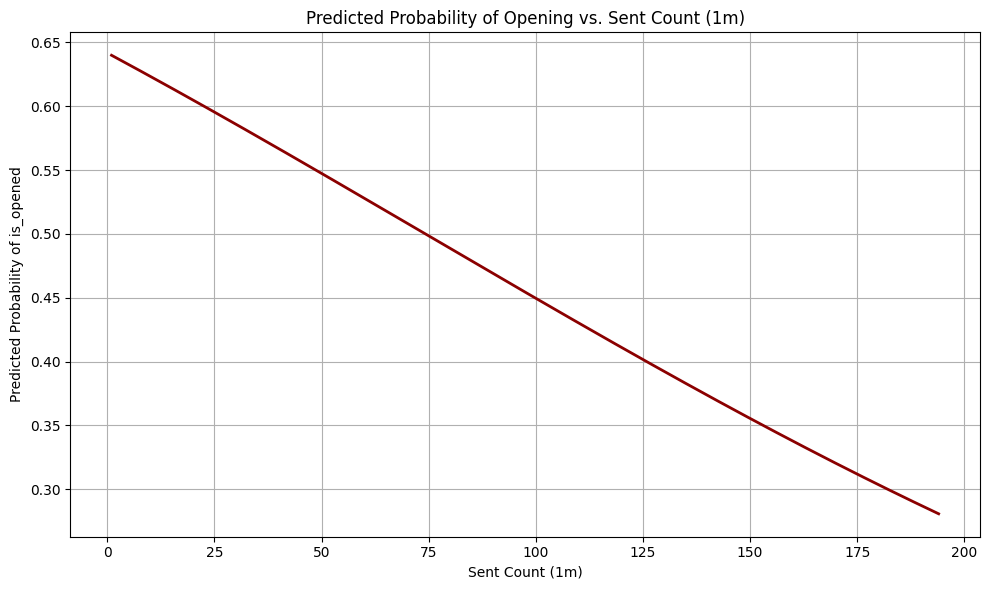

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# --- Step 1: Filter population ---
df_high_open = df[df['is_opened_rate_1m'] > 0.25].copy()

# --- Step 2: Prepare features and target ---
X = df_high_open[['sent_count_1m']]
y = df_high_open['is_opened']

# --- Step 3: Scale features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 4: Fit logistic regression ---
log_reg = LogisticRegression()
log_reg.fit(X_scaled, y)

# --- Step 5: Generate prediction curve ---
# Create a smooth range of sent_count_1m values
x_range = np.linspace(X['sent_count_1m'].min(), X['sent_count_1m'].max(), 200).reshape(-1,1)
x_range_scaled = scaler.transform(x_range)

# Predicted probabilities
y_pred_prob = log_reg.predict_proba(x_range_scaled)[:,1]

# --- Step 6: Plot ---
plt.figure(figsize=(10,6))
plt.plot(x_range, y_pred_prob, color='darkred', linewidth=2)

plt.title("Predicted Probability of Opening vs. Sent Count (1m)")
plt.xlabel("Sent Count (1m)")
plt.ylabel("Predicted Probability of is_opened")
plt.grid(True)
plt.tight_layout()
plt.show()

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# --- Step 1: Prepare dataset ---
df_for_model = df[['sent_count_1m',"sent_count_1d", 'total_msgs', 'market_avg_msgs_6h',
                    'market_avg_msgs_1d', 'market_avg_msgs_1w', 'market_avg_msgs_1m',
                    'is_opened_rate_1m', 'is_opened_rate_1w', 
                    'is_opened_rate_prev_smooth', 'is_opened']].dropna()

# --- Step 2: Collect results in a list ---
results = []

for threshold in [i/100 for i in range(5, 100, 5)]:  # 0.05, 0.10, ..., 0.95
    df_thresh = df_for_model[df_for_model['is_opened_rate_1m'] > threshold]
    
    if df_thresh.empty:
        continue
    
    X = df_thresh[['is_opened_rate_prev_smooth']]
    y = df_thresh['is_opened']
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Fit logistic regression
    log_reg = LogisticRegression()
    log_reg.fit(X_train_scaled, y_train)
    
    # Predict and evaluate
    y_pred = log_reg.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    
    # Append results
    results.append({
        'Threshold': threshold,
        'Accuracy': acc,
        'Intercept': log_reg.intercept_[0],
        'Coef_sent_count_1m': log_reg.coef_[0][0]
    })

# --- Step 3: Convert to DataFrame ---
results_df = pd.DataFrame(results)

print("\nLogistic Regression Results by Threshold:")
print(results_df)


Logistic Regression Results by Threshold:
    Threshold  Accuracy  Intercept  Coef_sent_count_1m
0        0.05  0.699843   0.009853            1.171213
1        0.10  0.681203   0.223980            1.073084
2        0.15  0.677071   0.396027            0.978484
3        0.20  0.669906   0.577858            0.880414
4        0.25  0.666281   0.724013            0.809242
5        0.30  0.677825   0.826924            0.770886
6        0.35  0.698832   0.948509            0.720481
7        0.40  0.727321   1.074400            0.680414
8        0.45  0.749170   1.174803            0.659674
9        0.50  0.778986   1.375214            0.599246
10       0.55  0.794955   1.453247            0.580233
11       0.60  0.819592   1.618703            0.524292
12       0.65  0.833011   1.721391            0.482121
13       0.70  0.850159   1.872032            0.421405
14       0.75  0.871048   1.994890            0.373930
15       0.80  0.891001   2.076574            0.357072
16       0.85  0.89696

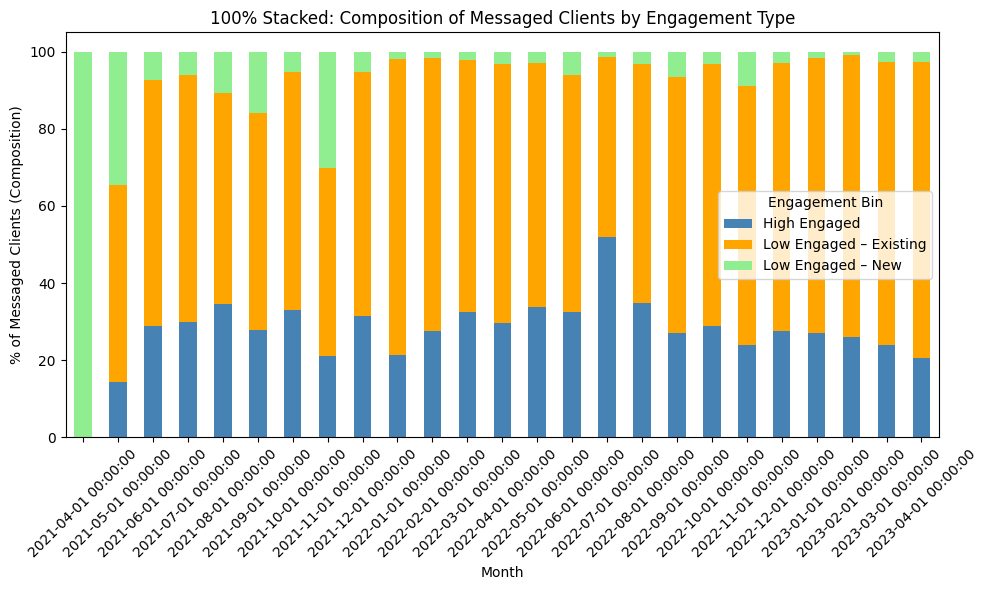

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Define threshold and bins ---
threshold = 0.05
df['engagement_bin'] = (df['is_opened_rate_1m'] >= threshold).map({True:'High Engaged', False:'Low Engaged'})

# --- Step 2: Identify first appearance month for each client ---
df['first_month'] = df.groupby('client_id')['month'].transform('min')
df['is_new'] = (df['month'] == df['first_month']).astype(int)

# --- Step 3: Restrict to messaged clients ---
df_messaged = df[df['sent_count_1m'] > 0].copy()

# --- Step 4: Create refined bins ---
def refine_bin(row):
    if row['engagement_bin'] == 'High Engaged':
        return 'High Engaged'
    elif row['engagement_bin'] == 'Low Engaged' and row['is_new'] == 1:
        return 'Low Engaged – New'
    else:
        return 'Low Engaged – Existing'

df_messaged['refined_bin'] = df_messaged.apply(refine_bin, axis=1)

# --- Step 5: Count messaged clients per month/refined bin ---
grp = (
    df_messaged.groupby(['month','refined_bin'])['client_id']
    .nunique()
    .reset_index(name='messaged_count')
)

# --- Step 6: Convert to 100% stacked composition ---
total_per_month = grp.groupby('month')['messaged_count'].sum().rename('total')
grp = grp.merge(total_per_month, on='month')
grp['share_pct'] = grp['messaged_count'] / grp['total'] * 100

pivot_norm = grp.pivot(index='month', columns='refined_bin', values='share_pct').fillna(0)

# --- Step 7: Plot ---
pivot_norm.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color={
        'High Engaged':'steelblue',
        'Low Engaged – Existing':'orange',
        'Low Engaged – New':'lightgreen'
    }
)

plt.title("100% Stacked: Composition of Messaged Clients by Engagement Type")
plt.xlabel("Month")
plt.ylabel("% of Messaged Clients (Composition)")
plt.legend(title="Engagement Bin")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [47]:
for feature, coef in zip(X.columns, log_reg.coef_[0]):
    print(f"{feature}: {coef}")

sent_count_1m: 0.15342864532767553
is_opened_rate_1m: 1.7112734593448493


In [73]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
# import statsmodels.api as sm

# --- Example setup ---
# Assume df has columns: user_id, month, sent_count_1m, is_opened_rate_1m
# Ensure month is datetime
df['month'] = pd.to_datetime(df['date'].astype(str).str.slice(0, 7))

# --- Step 1: Sort by user and month ---
df = df.sort_values(['client_id','month'])

# --- Step 2: Create next-month target ---
# Shift sent_count_1m by -1 within each user to get next month’s value
df['sent_count_next_month'] = df.groupby('client_id')['sent_count_1m'].shift(-1)

# Drop rows where next month’s value is missing (last month per user)
df_model = df.dropna(subset = ['sent_count_next_month', 'is_opened_rate_1m', 'sent_count_1m'])

# --- Step 3: Define features (current month) and target (next month) ---
X = df_model[['is_opened_rate_1m']]
y = df_model['sent_count_next_month']

# --- Step 4: Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 5: Fit regression model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Step 6: Evaluate ---
y_pred = model.predict(X_test)

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R^2 score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
# Print summary
# print(model.summary())

Coefficients: [2.67829665]
Intercept: 8.229672555659215
R^2 score: 0.02072732638123853
RMSE: 5.78673828918348


In [75]:
# Simple correlation
correlation = df['is_opened_rate_1m'].corr(df['sent_count_1m'])
print("Correlation:", correlation)

Correlation: 0.14538528600516593


In [76]:
df['date'].astype(str).str.slice(0, 7)

0          2021-11
1          2022-01
2          2022-01
3          2022-01
4          2022-01
            ...   
1562016    2023-04
1562017    2023-04
1562018    2023-04
1562019    2023-04
1562020    2023-04
Name: date, Length: 1562021, dtype: object


Monthly average sent_count by engagement group (restricted to first-month clients):
            Low Engaged  High Engaged
month                                
2021-04-01     1.167209           NaN
2021-05-01     4.632419     11.692308
2021-06-01     5.776224     10.177570
2021-07-01     7.829841     11.682028
2021-08-01    13.363291     16.678019
2021-09-01    10.976314     14.032258
2021-10-01    11.460411     13.746696
2021-11-01    10.461014     16.621239
2021-12-01     9.722941     14.460674
2022-01-01     8.346857     12.455301
2022-02-01    10.240199     12.970819
2022-03-01    11.721339     13.601440
2022-04-01    10.720670     16.508227
2022-05-01     9.215025     12.492564
2022-06-01     9.845531     11.060082
2022-07-01    12.126933     13.113636
2022-08-01    11.883411     16.277076
2022-09-01     8.155877     11.771511
2022-10-01    11.914115     13.212778
2022-11-01    13.814926     17.284112
2022-12-01    13.971178     17.765900
2023-01-01    11.635442     14.049029
202

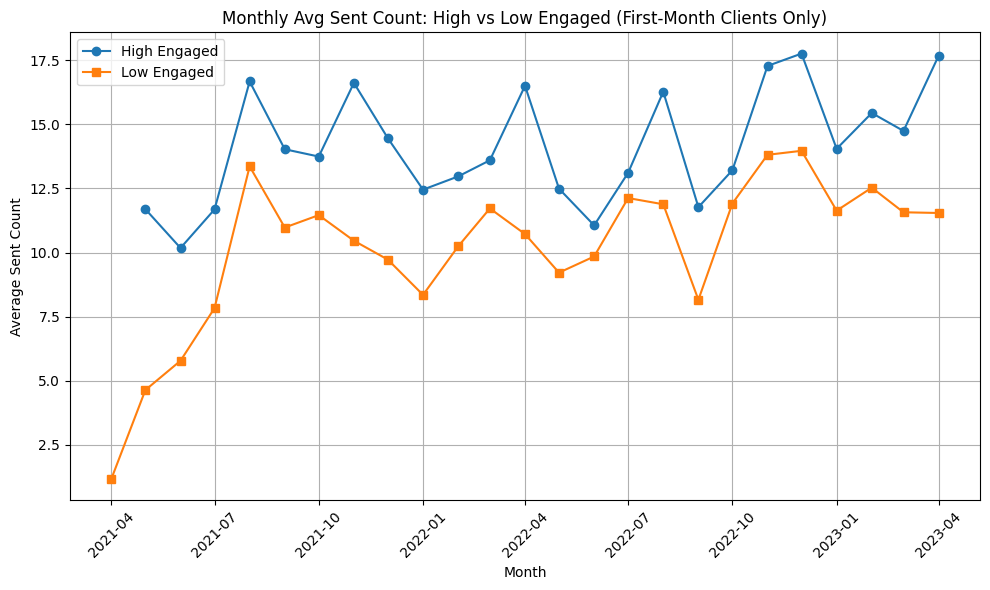

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Fix client base to those who were sent messages in the first month ---
first_month = df['month'].min()   # identify first month in dataset
clients_first_month = df.loc[df['month'] == first_month, 'client_id'].unique()

df_fixed = df[df['client_id'].isin(clients_first_month)].copy()

# --- Step 2: Define engagement bins (using median or quantile threshold) ---
threshold = 0.05
# df_fixed['is_opened_rate_1m'].quantile(0.50)  # median split
df_fixed['high_engaged'] = (df_fixed['is_opened_rate_1w'] >= threshold).astype(int)

# --- Step 3: Calculate average sent_count per month for each bin ---
monthly_avg = (
    df_fixed.groupby(['month','high_engaged'])['sent_count_next_month']
    .mean()
    .reset_index()
)

# Pivot for plotting
pivot_avg = monthly_avg.pivot(index='month', columns='high_engaged', values='sent_count_next_month')
pivot_avg.columns = ['Low Engaged','High Engaged']

print("\nMonthly average sent_count by engagement group (restricted to first-month clients):")
print(pivot_avg)

# --- Step 4: Plot ---
plt.figure(figsize=(10,6))
plt.plot(pivot_avg.index, pivot_avg['High Engaged'], marker='o', label='High Engaged')
plt.plot(pivot_avg.index, pivot_avg['Low Engaged'], marker='s', label='Low Engaged')

plt.title("Monthly Avg Sent Count: High vs Low Engaged (First-Month Clients Only)")
plt.xlabel("Month")
plt.ylabel("Average Sent Count")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [90]:
df_fixed['high_engaged'].sum() / df_fixed['high_engaged'].count()

np.float64(0.28497063958101887)

<Axes: >

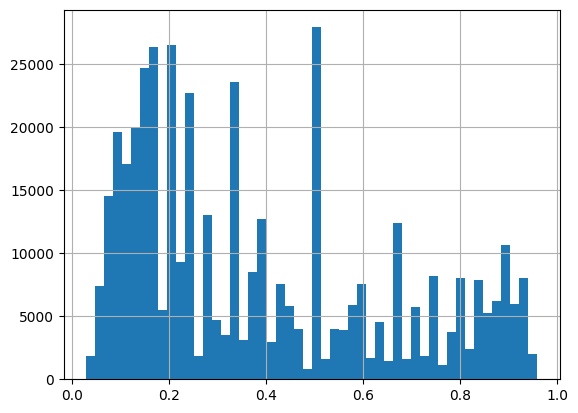

In [93]:
df[(df['is_opened_rate_1m'] > 0) & (df['is_opened_rate_1m'] < 1)].is_opened_rate_1m.hist(bins=50)

In [79]:
threshold

np.float64(0.0)


Percentage of clients messaged each month by engagement bin:
                           month           bin  pct_with_message
0  1970-01-01 00:00:00.000000001   Low Engaged         14.718954
1  1970-01-01 00:00:00.000000001  High Engaged        100.000000
2  1970-01-01 00:00:00.000000002   Low Engaged         27.091633
3  1970-01-01 00:00:00.000000002  High Engaged        100.000000
4  1970-01-01 00:00:00.000000003   Low Engaged          6.014401
5  1970-01-01 00:00:00.000000003  High Engaged        100.000000
6  1970-01-01 00:00:00.000000004   Low Engaged          2.729632
7  1970-01-01 00:00:00.000000004  High Engaged        100.000000
8  1970-01-01 00:00:00.000000005   Low Engaged         22.775606
9  1970-01-01 00:00:00.000000005  High Engaged        100.000000
10 1970-01-01 00:00:00.000000006   Low Engaged         26.166407
11 1970-01-01 00:00:00.000000006  High Engaged        100.000000
12 1970-01-01 00:00:00.000000007   Low Engaged         17.162162
13 1970-01-01 00:00:00.00000

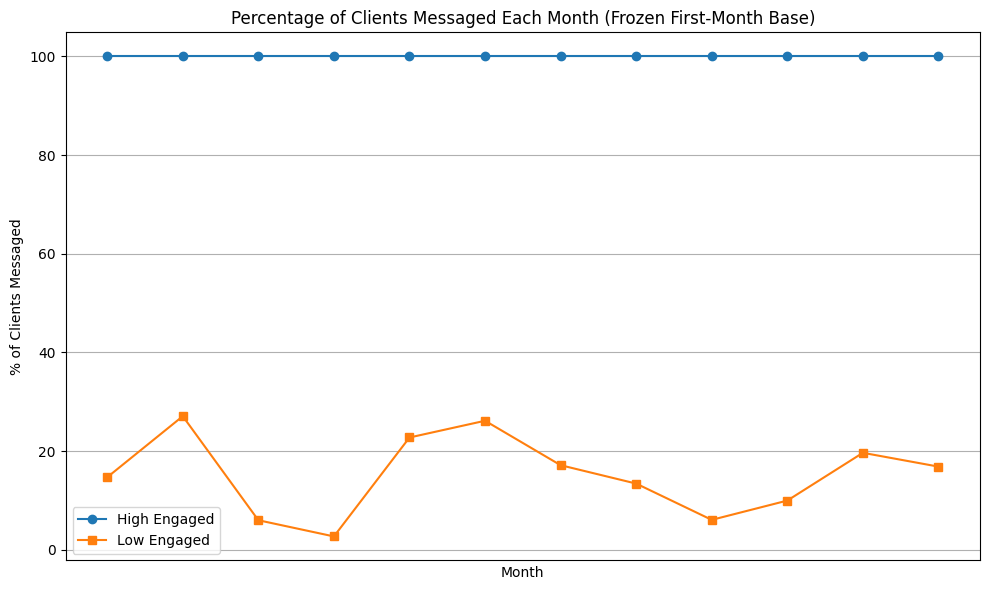

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Identify first month and freeze client base ---
first_month = df['month'].min()
clients_first_month = df.loc[df['month'] == first_month, 'client_id'].unique()

df_fixed = df[df['client_id'].isin(clients_first_month)].copy()

# --- Step 2: Define engagement bins based on first month open rate ---
threshold = df_fixed.loc[df_fixed['month'] == first_month, 'is_opened_rate_1m'].quantile(0.70)
df_fixed['high_engaged'] = (df_fixed['is_opened_rate_1m'] >= threshold).astype(int)

# --- Step 3: For each month, calculate % of clients in each bin that got >=1 message ---
results = (
    df_fixed.groupby(['month','high_engaged'])['sent_count_1m']
    .apply(lambda x: (x > 0).mean() * 100)   # percentage with at least 1 message
    .reset_index(name='pct_with_message')
)

# Map bin labels
results['bin'] = results['high_engaged'].map({0:'Low Engaged', 1:'High Engaged'})

print("\nPercentage of clients messaged each month by engagement bin:")
print(results[['month','bin','pct_with_message']])

# --- Step 4: Pivot for plotting ---
pivot_results = results.pivot(index='month', columns='bin', values='pct_with_message')

# --- Step 5: Plot time series ---
plt.figure(figsize=(10,6))
plt.plot(pivot_results.index, pivot_results['High Engaged'], marker='o', label='High Engaged')
plt.plot(pivot_results.index, pivot_results['Low Engaged'], marker='s', label='Low Engaged')

plt.title("Percentage of Clients Messaged Each Month (Frozen First-Month Base)")
plt.xlabel("Month")
plt.ylabel("% of Clients Messaged")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

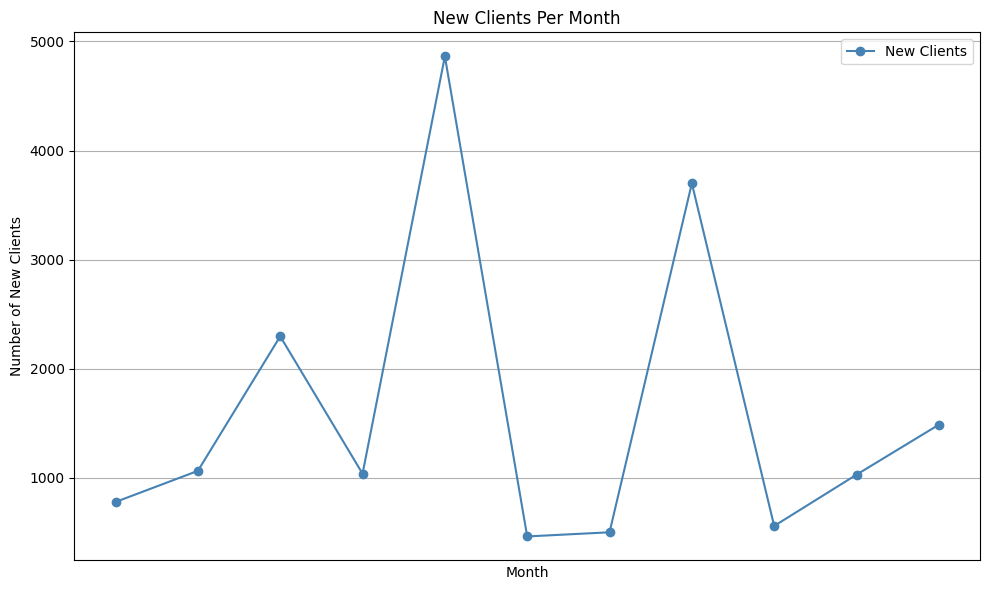

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure month is datetime
df['month'] = pd.to_datetime(df['month'])

# Sort by month
df = df.sort_values('month')

# --- Step 1: Identify first appearance of each client ---
df['first_month'] = df.groupby('client_id')['month'].transform('min')

# --- Step 2: Count new clients per month ---
new_clients_per_month = (
    df[df['month'] == df['first_month']]
    .groupby('month')['client_id']
    .nunique()
    .reset_index(name='new_clients_count')
)


new_clients_per_month = new_clients_per_month[1:]

# --- Step 3: Plot ---
plt.figure(figsize=(10,6))
plt.plot(new_clients_per_month['month'], new_clients_per_month['new_clients_count'],
         marker='o', color='steelblue', label='New Clients')

plt.title("New Clients Per Month")
plt.xlabel("Month")
plt.ylabel("Number of New Clients")
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Binned Relationship

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def analyze_binned_relationship(df, bin_column, target_column, num_bins=10, output_prefix=''):
    """
    Analyze relationship between two columns by binning one and averaging the other.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    bin_column : str
        Column name to bin (e.g., 'is_opened_rate_1m')
    target_column : str
        Column name to calculate average for (e.g., 'is_opened')
    num_bins : int
        Number of bins to create (default 10)
    output_prefix : str
        Prefix for output files (default empty string)
    
    Returns:
    --------
    DataFrame : binned_analysis with statistics for each bin
    """
    
    # Ensure datetime columns are datetime if needed
    df['sent_at'] = pd.to_datetime(df['sent_at'])
    
    # Create binned version
    # First, bin without labels to see how many unique bins we get
    binned_temp, bin_edges = pd.qcut(
        df[bin_column], 
        q=num_bins, 
        retbins=True,
        duplicates='drop'
    )
    
    # Calculate actual number of bins
    actual_bins = len(bin_edges) - 1
    print(f"Requested {num_bins} bins, but got {actual_bins} unique bins due to duplicate values")
    
    # Create labels based on bin ranges (e.g., "0.0-0.1", "0.1-0.2", etc.)
    labels = []
    for i in range(actual_bins):
        lower = bin_edges[i]
        upper = bin_edges[i + 1]
        labels.append(f'{lower:.2f}-{upper:.2f}')
    
    # Now create the binned column with correct number of labels
    binned_col_name = f'{bin_column}_binned'
    df[binned_col_name] = pd.qcut(
        df[bin_column], 
        q=num_bins, 
        labels=labels,
        duplicates='drop'
    )
    
    print(f"\nBinned groups created for {bin_column}:")
    print(df[binned_col_name].value_counts().sort_index())
    
    # Calculate statistics for each bin
    binned_analysis = df.groupby(binned_col_name, observed=True).agg({
        target_column: ['mean', 'count', 'std']
    }).reset_index()
    
    binned_analysis.columns = [binned_col_name, f'avg_{target_column}', 'count', f'std_{target_column}']
    
    print("\n" + "="*70)
    print(f"Analysis: How {target_column} changes with {bin_column} bins")
    print("="*70)
    print(binned_analysis.to_string())
    
    # ========== Visualization 1: Line plot with error bars ==========
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x_pos = np.arange(len(binned_analysis))
    avg_col = f'avg_{target_column}'
    std_col = f'std_{target_column}'
    
    ax.plot(
        x_pos, 
        binned_analysis[avg_col], 
        marker='o', 
        linestyle='-', 
        linewidth=2.5,
        markersize=8,
        color='steelblue',
        label=f'Average {target_column}'
    )
    
    # Add error bars (std dev)
    ax.errorbar(
        x_pos, 
        binned_analysis[avg_col],
        yerr=binned_analysis[std_col],
        fmt='none',
        ecolor='gray',
        alpha=0.5,
        capsize=5,
        label='±1 Std Dev'
    )
    
    # Add count labels on points
    for i, (rate, count) in enumerate(zip(binned_analysis[avg_col], binned_analysis['count'])):
        ax.text(i, rate + 0.02, f'n={int(count)}', ha='center', fontsize=9, fontweight='bold')
    
    ax.set_xlabel(f'{bin_column} Bin Range', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Average {target_column}', fontsize=12, fontweight='bold')
    ax.set_title(f'Impact of {bin_column} on {target_column}', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(binned_analysis[binned_col_name], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=11)
    ax.set_ylim(0, max(binned_analysis[avg_col]) * 1.15)
    
    plt.tight_layout()
    filename1 = f'{output_prefix}line_plot.png' if output_prefix else 'line_plot.png'
    plt.savefig(filename1, dpi=300, bbox_inches='tight')
    print(f"\n✅ Saved: {filename1}")
    plt.show()
    
    # ========== Visualization 2: Bar plot ==========
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars = ax.bar(
        x_pos,
        binned_analysis[avg_col],
        color='steelblue',
        alpha=0.7,
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, binned_analysis[avg_col])):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{val:.1%}' if val < 1 else f'{val:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_xlabel(f'{bin_column} Bin Range', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Average {target_column}', fontsize=12, fontweight='bold')
    ax.set_title(f'{target_column} by {bin_column} Bin', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(binned_analysis[binned_col_name], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(binned_analysis[avg_col]) * 1.15)
    
    plt.tight_layout()
    filename2 = f'{output_prefix}bar_plot.png' if output_prefix else 'bar_plot.png'
    plt.savefig(filename2, dpi=300, bbox_inches='tight')
    print(f"✅ Saved: {filename2}")
    plt.show()
    
    # ========== Visualization 3: Box plot ==========
    fig, ax = plt.subplots(figsize=(14, 6))
    
    df.boxplot(
        column=target_column,
        by=binned_col_name,
        ax=ax,
        patch_artist=True,
        grid=False
    )
    
    ax.set_xlabel(f'{bin_column} Bin Range', fontsize=12, fontweight='bold')
    ax.set_ylabel(target_column, fontsize=12, fontweight='bold')
    ax.set_title(f'Distribution of {target_column} by {bin_column} Bin', fontsize=14, fontweight='bold')
    ax.set_xticklabels(binned_analysis[binned_col_name], rotation=45, ha='right')
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    plt.show()
    
    # ========== Summary Statistics ==========
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)
    print(f"Lowest bin average {target_column}: {binned_analysis[avg_col].iloc[0]:.1%}" if binned_analysis[avg_col].iloc[0] < 1 else f"Lowest bin average {target_column}: {binned_analysis[avg_col].iloc[0]:.4f}")
    print(f"Highest bin average {target_column}: {binned_analysis[avg_col].iloc[-1]:.1%}" if binned_analysis[avg_col].iloc[-1] < 1 else f"Highest bin average {target_column}: {binned_analysis[avg_col].iloc[-1]:.4f}")
    
    diff = binned_analysis[avg_col].iloc[-1] - binned_analysis[avg_col].iloc[0]
    print(f"Difference: {diff:.1%}" if abs(diff) < 1 else f"Difference: {diff:.4f}")
    
    if binned_analysis[avg_col].iloc[0] > 0:
        factor = binned_analysis[avg_col].iloc[-1] / binned_analysis[avg_col].iloc[0]
        print(f"Improvement factor: {factor:.2f}x")
    
    print(f"Total bins created: {actual_bins}")
    print("="*70)
    
    return binned_analysis

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def analyze_binned_feature(df, bin_col, agg_col, num_quantiles=10, agg_func='mean'):
    """
    Bin a column and analyze how another column changes across bins.
    
    Parameters:
    -----------
    df : DataFrame
        Your dataframe
    bin_col : str
        Column name to bin (x-axis)
    agg_col : str
        Column name to aggregate (y-axis)
    num_quantiles : int
        Number of quantiles for binning (default: 10)
    agg_func : str
        Aggregation function: 'mean', 'sum', 'count', etc.
        
    Returns:
    --------
    tuple : (binned_analysis DataFrame, bin_edges, num_bins)
    """
    
    # Ensure sent_at is datetime if needed
    df['sent_at'] = pd.to_datetime(df['sent_at'])
    
    # Create binned version - first pass to get actual number of bins
    binned_temp, bin_edges = pd.qcut(
        df[bin_col], 
        q=num_quantiles, 
        retbins=True,
        duplicates='drop'
    )
    
    # Calculate actual number of bins
    num_bins = len(bin_edges) - 1
    print(f"Requested {num_quantiles} bins, but got {num_bins} unique bins due to duplicate values")
    
    # Create range labels (0-0.2, 0.2-0.4, etc.)
    labels = [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(num_bins)]
    
    # Create the binned column with correct number of labels
    binned_col_name = f"{bin_col}_binned"
    df[binned_col_name] = pd.qcut(
        df[bin_col], 
        q=num_quantiles, 
        labels=labels,
        duplicates='drop'
    )
    
    print(f"\nBinned groups created:")
    print(df[binned_col_name].value_counts().sort_index())
    
    # Calculate statistics for each bin
    binned_analysis = df.groupby(binned_col_name, observed=True).agg({
        agg_col: [agg_func, 'count', 'std']
    }).reset_index()
    
    binned_analysis.columns = [binned_col_name, f'avg_{agg_col}', 'count', f'std_{agg_col}']
    
    print("\n" + "="*70)
    print(f"Analysis: How {agg_col} changes with {bin_col} bins")
    print("="*70)
    print(binned_analysis.to_string())
    
    return binned_analysis, bin_edges, num_bins, binned_col_name




In [34]:
def plot_binned_analysis(df, bin_col, agg_col, num_quantiles=10, agg_func='mean', save_prefix=''):
    """
    Complete binning analysis with all visualizations in one function.
    
    Parameters:
    -----------
    df : DataFrame
        Your dataframe
    bin_col : str
        Column name to bin (x-axis)
    agg_col : str
        Column name to aggregate (y-axis)
    num_quantiles : int
        Number of quantiles for binning (default: 10)
    agg_func : str
        Aggregation function: 'mean', 'sum', 'count', etc. (default: 'mean')
    save_prefix : str
        Prefix for saved plots (e.g., 'sent_count_' will save 'sent_count_line_plot.png')
        If empty, plots won't be saved
    
    Returns:
    --------
    DataFrame : binned_analysis with statistics
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    
    print(f"\n{'='*70}")
    print(f"BINNED ANALYSIS: {bin_col} vs {agg_col}")
    print(f"{'='*70}\n")
    
    # Ensure sent_at is datetime if needed
    df['sent_at'] = pd.to_datetime(df['sent_at'])
    
    # Create binned version - first pass to get actual number of bins
    binned_temp, bin_edges = pd.qcut(
        df[bin_col], 
        q=num_quantiles, 
        retbins=True,
        duplicates='drop'
    )
    
    # Calculate actual number of bins
    num_bins = len(bin_edges) - 1
    print(f"Requested {num_quantiles} bins, but got {num_bins} unique bins due to duplicate values\n")
    
    # Create range labels (0.00-0.20, 0.20-0.40, etc.)
    labels = [f"{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}" for i in range(num_bins)]
    
    # Create the binned column with correct number of labels
    binned_col_name = f"{bin_col}_binned"
    df[binned_col_name] = pd.qcut(
        df[bin_col], 
        q=num_quantiles, 
        labels=labels,
        duplicates='drop'
    )
    
    print(f"Binned groups created:")
    print(df[binned_col_name].value_counts().sort_index())
    
    # Calculate statistics for each bin
    binned_analysis = df.groupby(binned_col_name, observed=True).agg({
        agg_col: [agg_func, 'count', 'std']
    }).reset_index()
    
    binned_analysis.columns = [binned_col_name, f'avg_{agg_col}', 'count', f'std_{agg_col}']
    
    print(f"\nAnalysis: How {agg_col} changes with {bin_col} bins")
    print(f"{'='*70}")
    print(binned_analysis.to_string())
    
    # ========== Visualization 1: Line plot with error bars ==========
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x_pos = np.arange(len(binned_analysis))
    ax.plot(
        x_pos, 
        binned_analysis[f'avg_{agg_col}'], 
        marker='o', 
        linestyle='-', 
        linewidth=2.5,
        markersize=8,
        color='steelblue',
        label=f'Average {agg_col}'
    )
    
    # Add error bars (std dev)
    ax.errorbar(
        x_pos, 
        binned_analysis[f'avg_{agg_col}'],
        yerr=binned_analysis[f'std_{agg_col}'],
        fmt='none',
        ecolor='gray',
        alpha=0.5,
        capsize=5,
        label='±1 Std Dev'
    )
    
    # Add count labels on points
    for i, (rate, count) in enumerate(zip(binned_analysis[f'avg_{agg_col}'], binned_analysis['count'])):
        ax.text(i, rate + 0.02, f'n={int(count)}', ha='center', fontsize=9, fontweight='bold')
    
    ax.set_xlabel(f'{bin_col} Range', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Average {agg_col}', fontsize=12, fontweight='bold')
    ax.set_title(f'Impact of {bin_col} on {agg_col}', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(binned_analysis[binned_col_name], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend(fontsize=11)
    ax.set_ylim(0, max(binned_analysis[f'avg_{agg_col}']) * 1.15)
    
    plt.tight_layout()
    if save_prefix:
        filename = f'{save_prefix}line_plot.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"\n✅ Saved: {filename}")
    plt.show()
    
    # ========== Visualization 2: Bar plot ==========
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bars = ax.bar(
        x_pos,
        binned_analysis[f'avg_{agg_col}'],
        color='steelblue',
        alpha=0.7,
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, binned_analysis[f'avg_{agg_col}'])):
        height = bar.get_height()
        # Format as percentage if < 1, else as decimal
        val_str = f'{val:.1%}' if val < 1 else f'{val:.2f}'
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                val_str,
                ha='center', va='bottom', fontweight='bold', fontsize=10)
    
    ax.set_xlabel(f'{bin_col} Range', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'Average {agg_col}', fontsize=12, fontweight='bold')
    ax.set_title(f'{agg_col} by {bin_col} Bin', fontsize=14, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(binned_analysis[binned_col_name], rotation=45, ha='right')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, max(binned_analysis[f'avg_{agg_col}']) * 1.15)
    
    plt.tight_layout()
    if save_prefix:
        filename = f'{save_prefix}bar_plot.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {filename}")
    plt.show()
    
    # ========== Visualization 3: Box plot ==========
    fig, ax = plt.subplots(figsize=(14, 6))
    
    df.boxplot(
        column=agg_col,
        by=binned_col_name,
        ax=ax,
        patch_artist=True,
        grid=False
    )
    
    ax.set_xlabel(f'{bin_col} Range', fontsize=12, fontweight='bold')
    ax.set_ylabel(agg_col, fontsize=12, fontweight='bold')
    ax.set_title(f'Distribution of {agg_col} by {bin_col} Bin', fontsize=14, fontweight='bold')
    ax.set_xticklabels(binned_analysis[binned_col_name], rotation=45, ha='right')
    plt.suptitle('')  # Remove automatic title
    plt.tight_layout()
    
    if save_prefix:
        filename = f'{save_prefix}box_plot.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"✅ Saved: {filename}")
    plt.show()
    
    # ========== Summary Statistics ==========
    print("\n" + "="*70)
    print("KEY INSIGHTS")
    print("="*70)
    
    avg_col = f'avg_{agg_col}'
    lowest_val = binned_analysis[avg_col].iloc[0]
    highest_val = binned_analysis[avg_col].iloc[-1]
    
    # Format values based on scale
    if lowest_val < 1:
        print(f"Lowest bin average {agg_col}: {lowest_val:.1%}")
        print(f"Highest bin average {agg_col}: {highest_val:.1%}")
    else:
        print(f"Lowest bin average {agg_col}: {lowest_val:.4f}")
        print(f"Highest bin average {agg_col}: {highest_val:.4f}")
    
    diff = highest_val - lowest_val
    if abs(diff) < 1:
        print(f"Difference: {diff:.1%}")
    else:
        print(f"Difference: {diff:.4f}")
    
    if lowest_val > 0:
        factor = highest_val / lowest_val
        print(f"Improvement factor: {factor:.2f}x")
    
    print(f"Total bins created: {num_bins}")
    print("="*70 + "\n")
    
    return binned_analysis



EXAMPLE 1: Open Rate vs Open Status

BINNED ANALYSIS: is_opened_rate_1m vs is_opened

Requested 10 bins, but got 4 unique bins due to duplicate values

Binned groups created:
is_opened_rate_1m_binned
0.00-0.14    1023505
0.14-0.36     145987
0.36-0.83     149909
0.83-1.00     140616
Name: count, dtype: int64

Analysis: How is_opened changes with is_opened_rate_1m bins
  is_opened_rate_1m_binned  avg_is_opened    count  std_is_opened
0                0.00-0.14       0.035441  1023505       0.184892
1                0.14-0.36       0.203683   145987       0.402737
2                0.36-0.83       0.515239   149909       0.499769
3                0.83-1.00       0.866786   140616       0.339807

✅ Saved: open_rate_line_plot.png


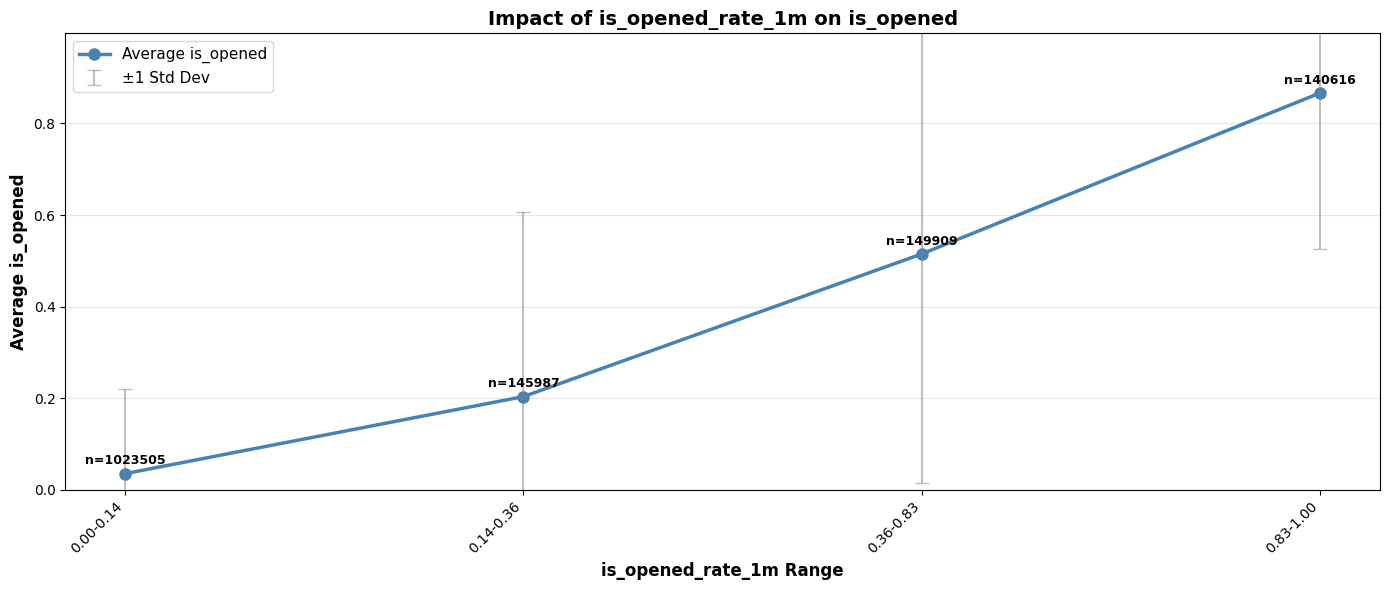

✅ Saved: open_rate_bar_plot.png


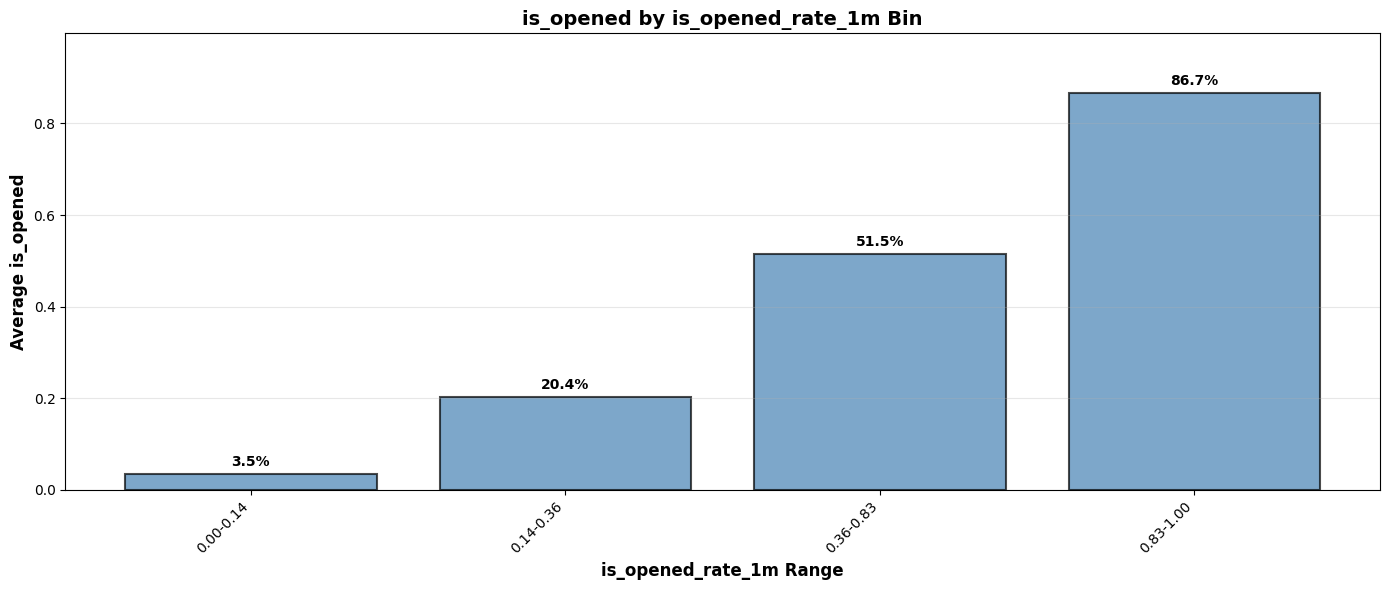

✅ Saved: open_rate_box_plot.png


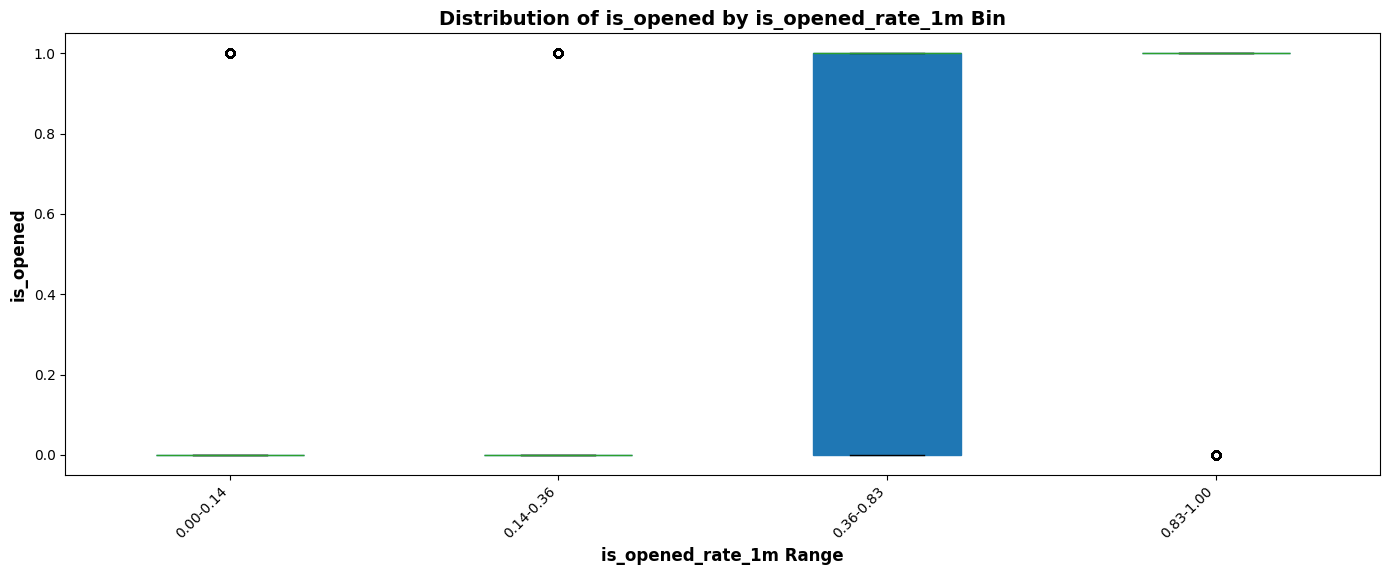


KEY INSIGHTS
Lowest bin average is_opened: 3.5%
Highest bin average is_opened: 86.7%
Difference: 83.1%
Improvement factor: 24.46x
Total bins created: 4



In [35]:

# Example usage 1: Analyze is_opened_rate_1m vs is_opened
print("EXAMPLE 1: Open Rate vs Open Status")
binned_analysis_1 = plot_binned_analysis(
    df, 
    bin_col='is_opened_rate_1m',
    agg_col='is_opened',
    num_quantiles=10,
    agg_func='mean',
    save_prefix='open_rate_'
)





EXAMPLE 2: Message Count vs Open Status

BINNED ANALYSIS: sent_count_1m vs is_opened

Requested 20 bins, but got 15 unique bins due to duplicate values

Binned groups created:
sent_count_1m_binned
1.00-2.00       168274
2.00-3.00        93205
3.00-4.00       111552
4.00-5.00       126945
5.00-6.00       133278
6.00-7.00       128195
7.00-8.00       122042
8.00-9.00       124139
9.00-10.00      100071
10.00-11.00      63882
11.00-12.00      49520
12.00-13.00      44284
13.00-15.00      72094
15.00-19.00      80582
19.00-194.00     65699
Name: count, dtype: int64

Analysis: How is_opened changes with sent_count_1m bins
   sent_count_1m_binned  avg_is_opened   count  std_is_opened
0             1.00-2.00       0.116411  168274       0.320718
1             2.00-3.00       0.148447   93205       0.355544
2             3.00-4.00       0.140401  111552       0.347404
3             4.00-5.00       0.157084  126945       0.363881
4             5.00-6.00       0.160071  133278       0.366674
5

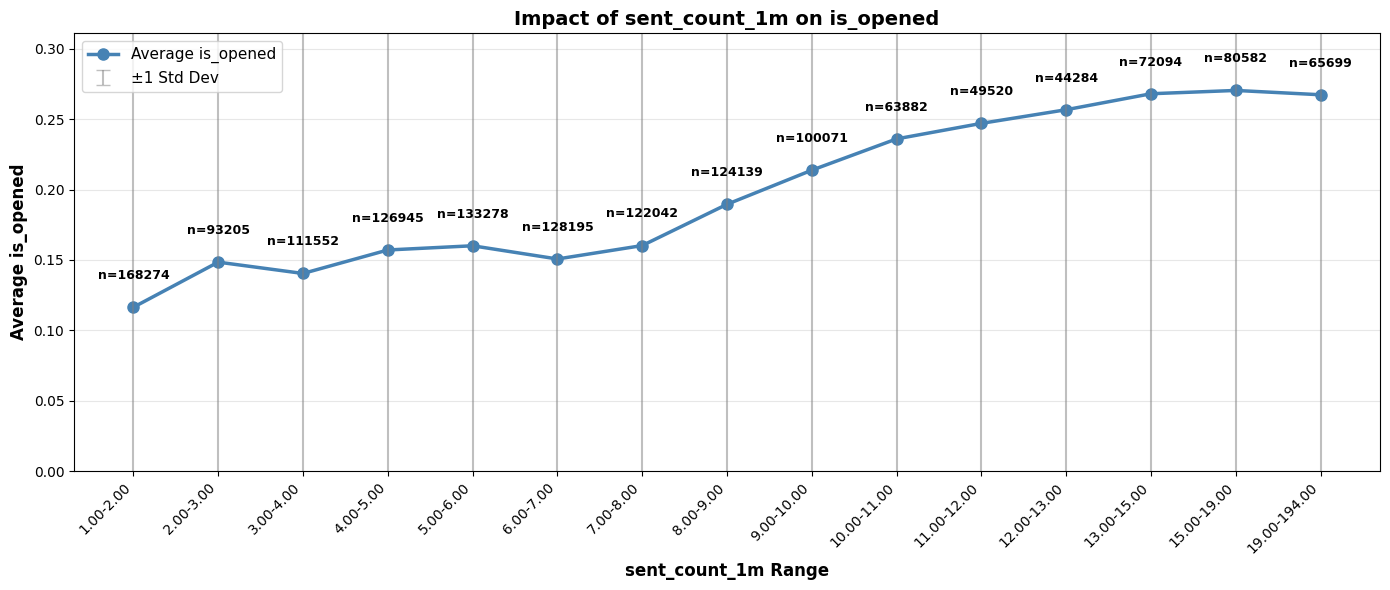

✅ Saved: sent_count_bar_plot.png


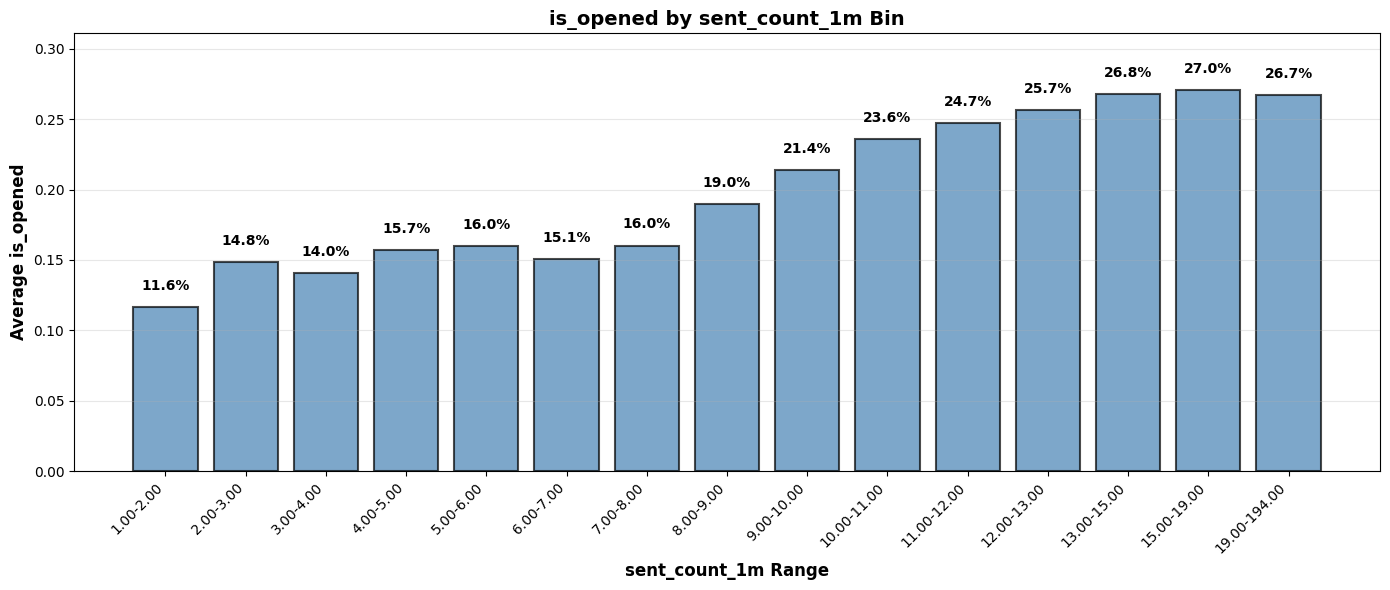

✅ Saved: sent_count_box_plot.png


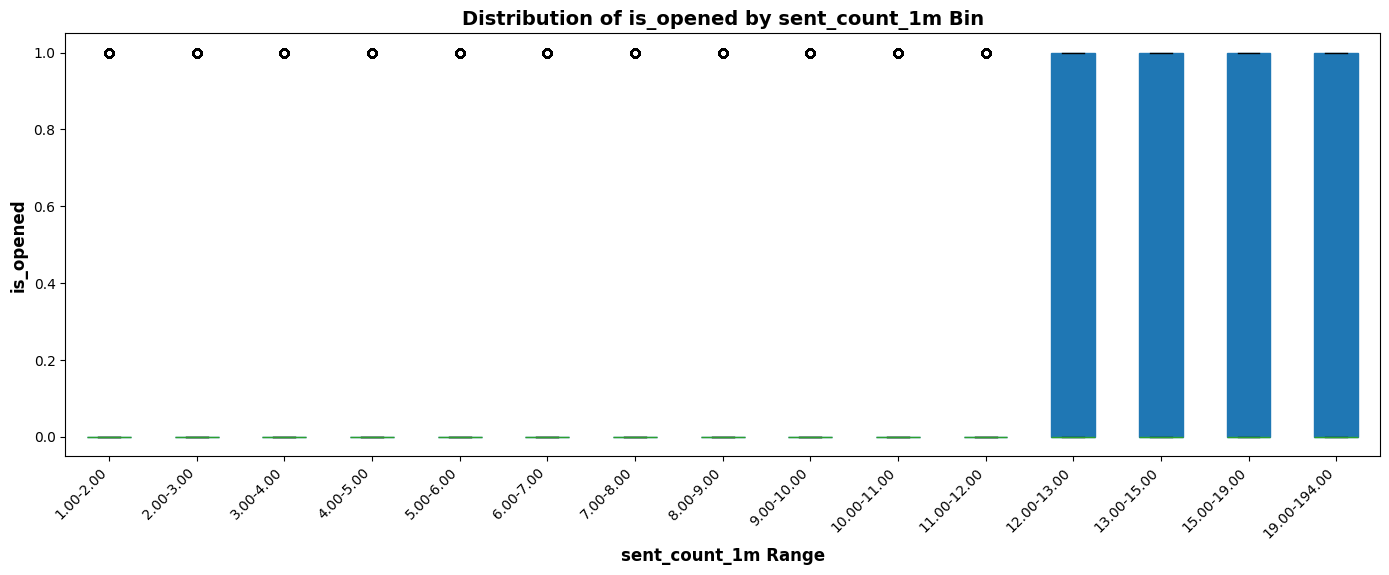


KEY INSIGHTS
Lowest bin average is_opened: 11.6%
Highest bin average is_opened: 26.7%
Difference: 15.1%
Improvement factor: 2.30x
Total bins created: 15



In [36]:
# Example usage 2: Analyze sent_count_1m vs is_opened
print("\n\nEXAMPLE 2: Message Count vs Open Status")
binned_analysis_2 = plot_binned_analysis(
    df, 
    bin_col='sent_count_1m',
    agg_col='is_opened',
    num_quantiles=20,
    agg_func='mean',
    save_prefix='sent_count_'
)



EXAMPLE 2: Message Count vs Open Status

BINNED ANALYSIS: total_msgs vs is_opened

Requested 20 bins, but got 20 unique bins due to duplicate values

Binned groups created:
total_msgs_binned
1.00-458.00        78771
458.00-693.00      77646
693.00-920.00      78087
920.00-1099.00     79040
1099.00-1258.00    77386
1258.00-1465.00    78347
1465.00-1690.00    78404
1690.00-1827.00    82170
1827.00-1969.00    73665
1969.00-2079.00    78523
2079.00-2255.00    77765
2255.00-2437.00    79273
2437.00-2659.00    78656
2659.00-2798.00    76434
2798.00-2976.00    80798
2976.00-3206.00    79908
3206.00-3381.00    75619
3381.00-3598.00    76237
3598.00-3946.00    79491
3946.00-4982.00    75801
Name: count, dtype: int64

Analysis: How is_opened changes with total_msgs bins
   total_msgs_binned  avg_is_opened  count  std_is_opened
0        1.00-458.00       0.197370  78771       0.398016
1      458.00-693.00       0.253690  77646       0.435125
2      693.00-920.00       0.220831  78087       0.41

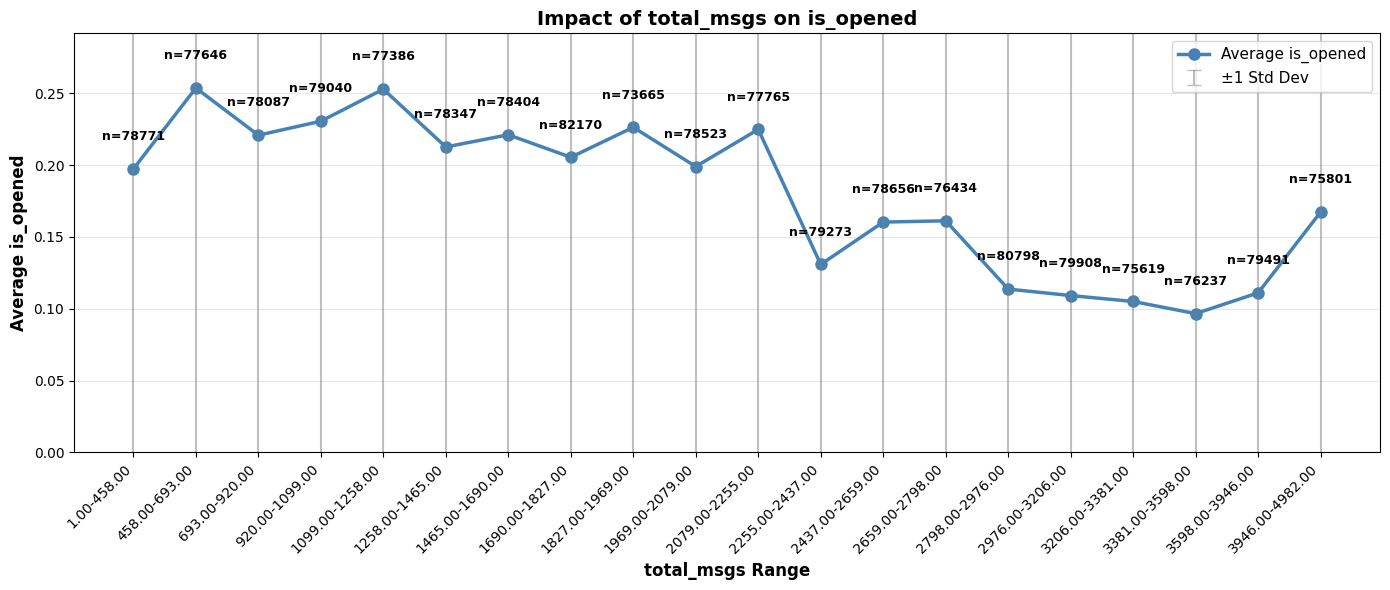

✅ Saved: market_avg_msgs_bar_plot.png


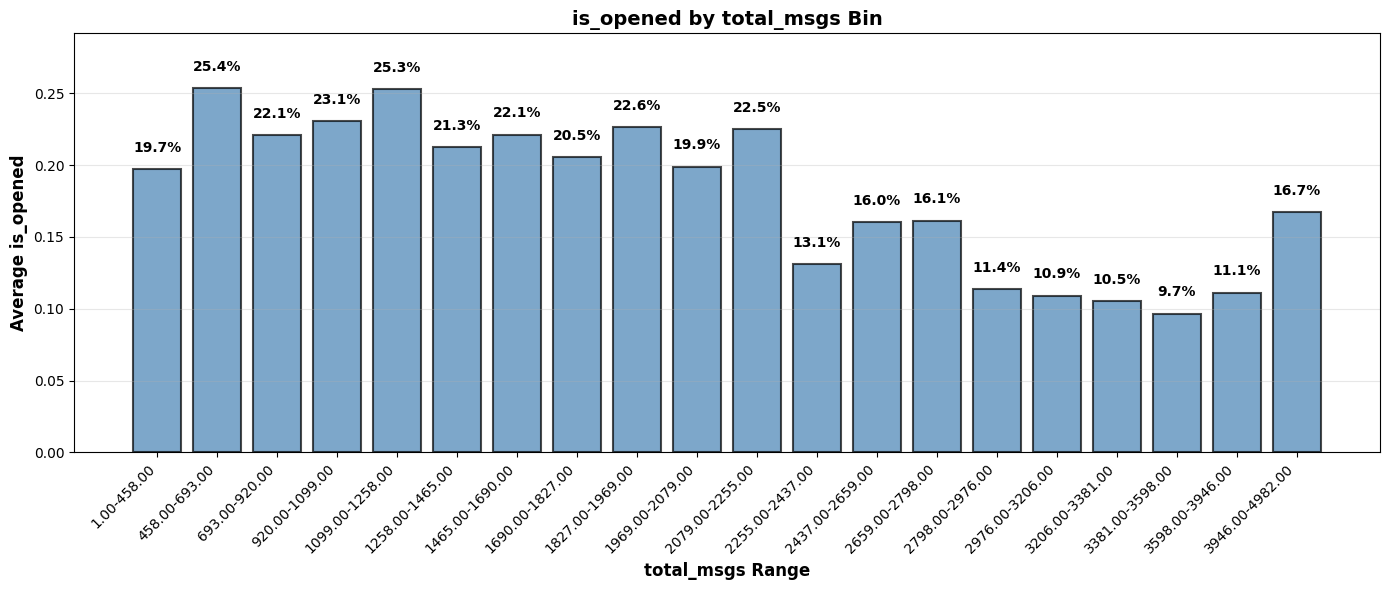

✅ Saved: market_avg_msgs_box_plot.png


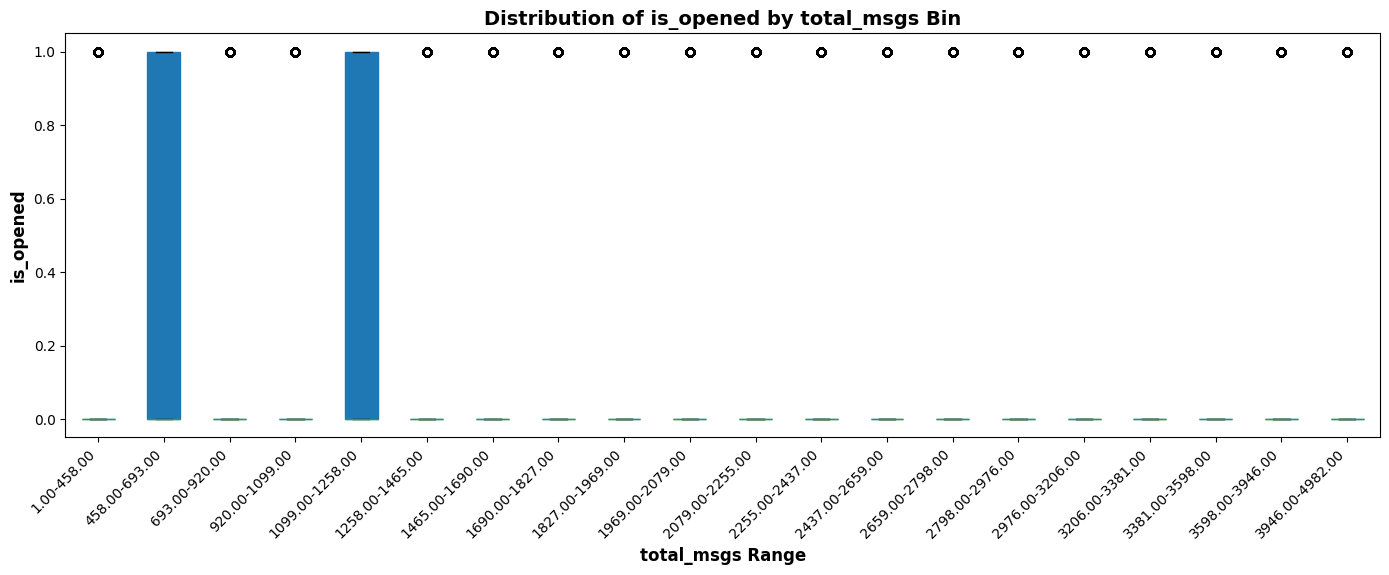


KEY INSIGHTS
Lowest bin average is_opened: 19.7%
Highest bin average is_opened: 16.7%
Difference: -3.0%
Improvement factor: 0.85x
Total bins created: 20



In [38]:
# Example usage 2: Analyze sent_count_1m vs is_opened
print("\n\nEXAMPLE 2: Message Count vs Open Status")
binned_analysis_2 = plot_binned_analysis(
    df, 
    bin_col='total_msgs',
    agg_col='is_opened',
    num_quantiles=20,
    agg_func='mean',
    save_prefix='market_avg_msgs_'
)



EXAMPLE 2: Message Count vs Open Status

BINNED ANALYSIS: market_avg_msgs_6h vs is_clicked

Requested 20 bins, but got 20 unique bins due to duplicate values

Binned groups created:
market_avg_msgs_6h_binned
0.50-4.00          80645
4.00-5.67          80708
5.67-6.83          83585
6.83-8.33          69572
8.33-10.83         78743
10.83-14.17        76070
14.17-34.67        79352
34.67-112.17       76245
112.17-166.17      78231
166.17-223.67      79247
223.67-295.50      78364
295.50-361.33      76693
361.33-436.50      81181
436.50-537.17      75445
537.17-619.25      77503
619.25-736.83      78096
736.83-932.33      79453
932.33-1137.67     76730
1137.67-1377.17    80031
1377.17-2542.33    76127
Name: count, dtype: int64

Analysis: How is_clicked changes with market_avg_msgs_6h bins
   market_avg_msgs_6h_binned  avg_is_clicked  count  std_is_clicked
0                  0.50-4.00        0.013863  80645        0.116924
1                  4.00-5.67        0.013580  80708        0.1157

/var/folders/bg/38ht234d5p50ytp9mrxf80nc0000gn/T/ipykernel_76482/3144406749.py:114: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()



✅ Saved: sent_count_line_plot.png


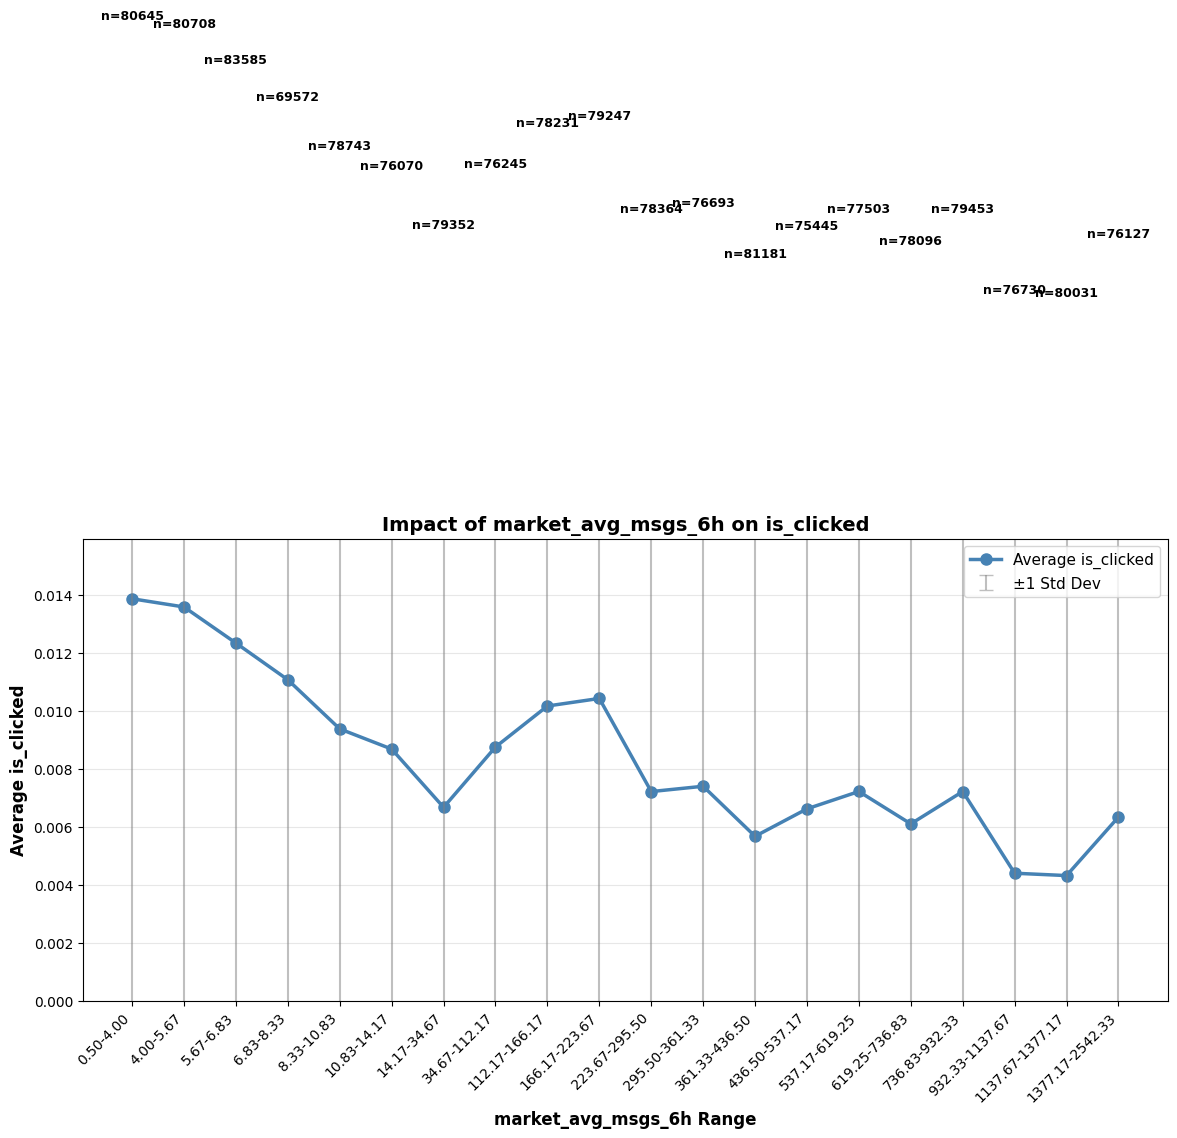

✅ Saved: sent_count_bar_plot.png


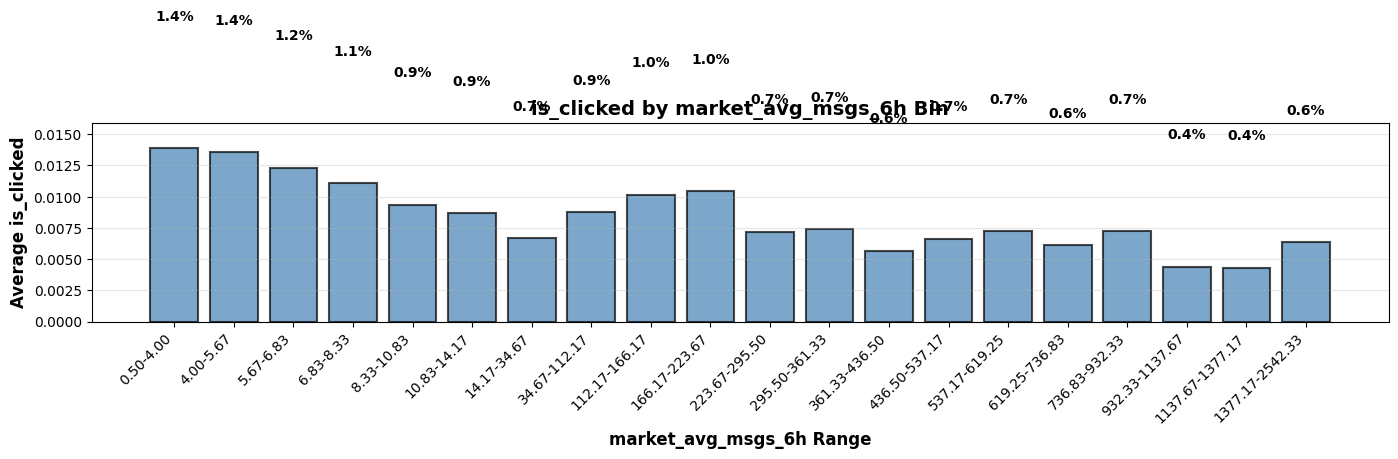

✅ Saved: sent_count_box_plot.png


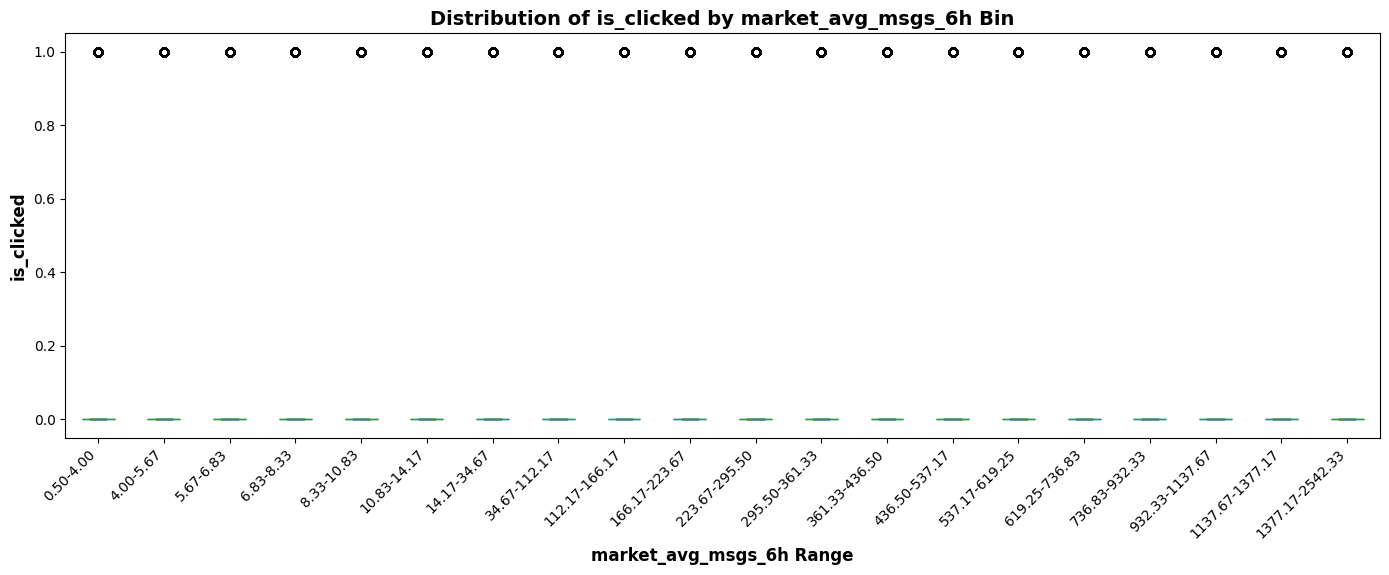


KEY INSIGHTS
Lowest bin average is_clicked: 1.4%
Highest bin average is_clicked: 0.6%
Difference: -0.8%
Improvement factor: 0.46x
Total bins created: 20



In [39]:
# Example usage 2: Analyze sent_count_1m vs is_opened
print("\n\nEXAMPLE 2: Message Count vs Open Status")
binned_analysis_2 = plot_binned_analysis(
    df, 
    bin_col='market_avg_msgs_6h',
    agg_col='is_clicked',
    num_quantiles=20,
    agg_func='mean',
    save_prefix='sent_count_'
)

In [ ]:
# Example usage 2: Analyze sent_count_1m vs is_opened
print("\n\nEXAMPLE 2: Message Count vs Open Status")
binned_analysis_2 = plot_binned_analysis(
    df, 
    bin_col='market_avg_msgs_6h',
    agg_col='is_opened',
    num_quantiles=20,
    agg_func='mean',
    save_prefix='sent_count_'
)



EXAMPLE 2: Message Count vs Open Status

BINNED ANALYSIS: sent_count_1w vs is_clicked

Requested 20 bins, but got 6 unique bins due to duplicate values

Binned groups created:
sent_count_1w_binned
1.00-2.00     862294
2.00-3.00     227611
3.00-4.00      94875
4.00-5.00      50306
5.00-6.00      29036
6.00-74.00     63124
Name: count, dtype: int64

Analysis: How is_clicked changes with sent_count_1w bins
  sent_count_1w_binned  avg_is_clicked   count  std_is_clicked
0            1.00-2.00        0.008898  862294        0.093911
1            2.00-3.00        0.008431  227611        0.091433
2            3.00-4.00        0.010751   94875        0.103129
3            4.00-5.00        0.012981   50306        0.113192
4            5.00-6.00        0.016359   29036        0.126854
5           6.00-74.00        0.026440   63124        0.160441

✅ Saved: sent_count_line_plot.png

Analysis: How is_clicked changes with sent_count_1w bins
  sent_count_1w_binned  avg_is_clicked   count  std_is_cl

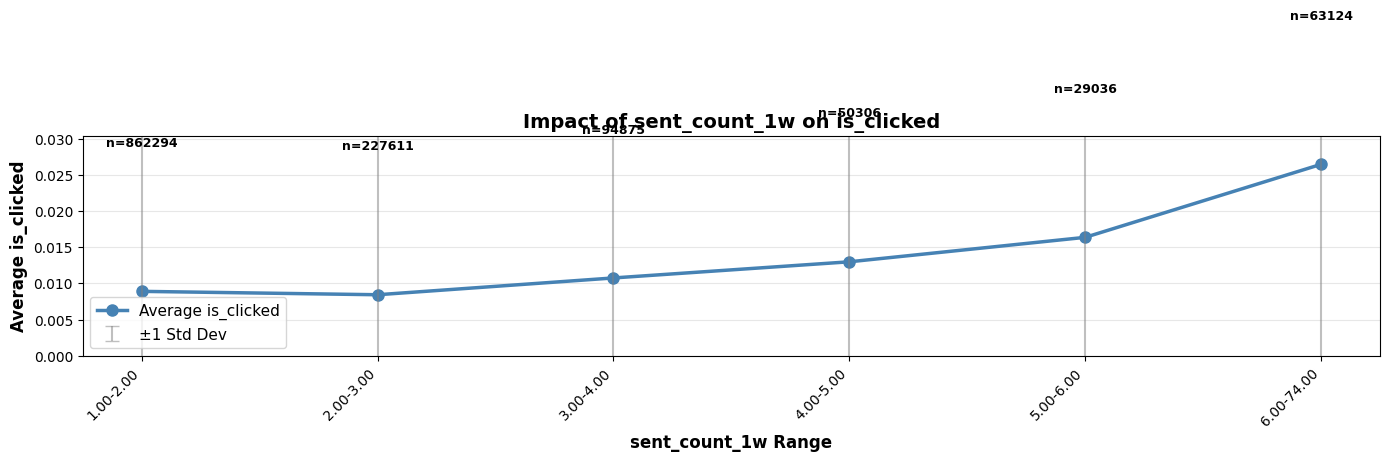

✅ Saved: sent_count_bar_plot.png


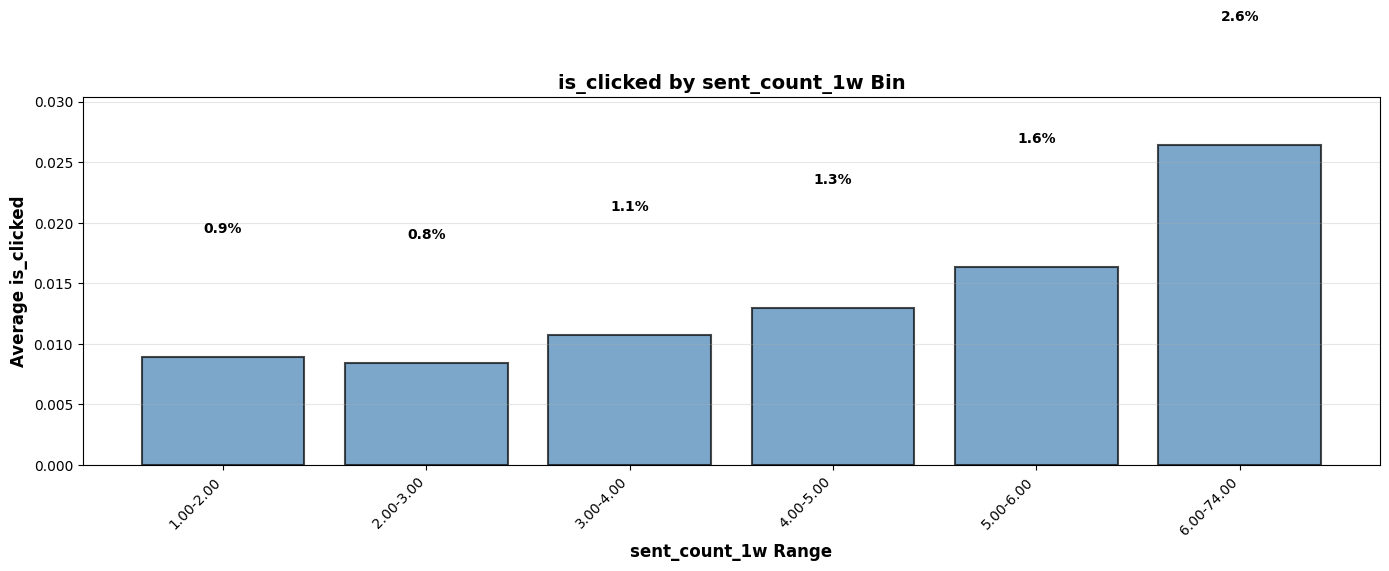

✅ Saved: sent_count_box_plot.png


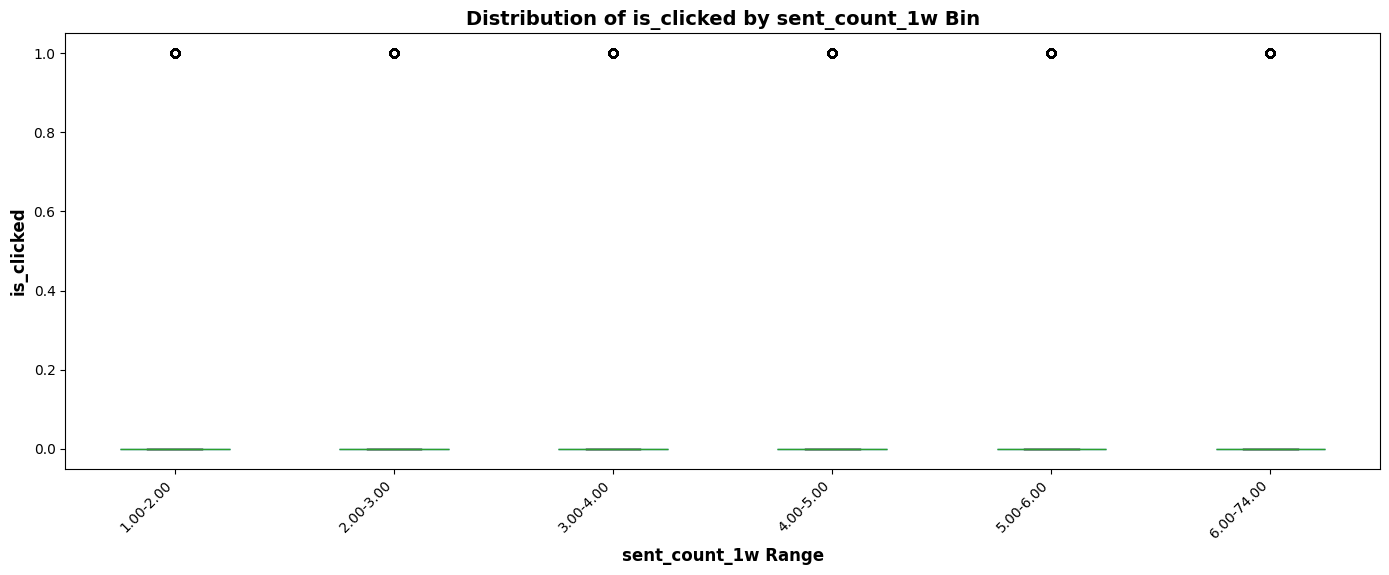


KEY INSIGHTS
Lowest bin average is_clicked: 0.9%
Highest bin average is_clicked: 2.6%
Difference: 1.8%
Improvement factor: 2.97x
Total bins created: 6



In [59]:
# Example usage 2: Analyze sent_count_1m vs is_opened
print("\n\nEXAMPLE 2: Message Count vs Open Status")
binned_analysis_2 = plot_binned_analysis(
    df, 
    bin_col='sent_count_1w',
    agg_col='is_clicked',
    num_quantiles=20,
    agg_func='mean',
    save_prefix='sent_count_'
)



EXAMPLE 2: Message Count vs Open Status

BINNED ANALYSIS: market_avg_msgs_1w vs is_opened

Requested 20 bins, but got 20 unique bins due to duplicate values

Binned groups created:
market_avg_msgs_1w_binned
5.09-30.43       84002
30.43-47.00      84414
47.00-55.97      83598
55.97-65.62      84630
65.62-74.23      83364
74.23-85.70      84664
85.70-94.18      83391
94.18-103.27     84046
103.27-112.10    85732
112.10-119.57    83145
119.57-126.12    85829
126.12-135.73    81225
135.73-145.89    84358
145.89-156.17    84824
156.17-168.53    84752
168.53-185.27    84011
185.27-197.24    85099
197.24-216.53    81122
216.53-249.47    86308
249.47-619.25    81499
Name: count, dtype: int64

Analysis: How is_opened changes with market_avg_msgs_1w bins
   market_avg_msgs_1w_binned  avg_is_opened  count  std_is_opened
0                 5.09-30.43       0.161865  84002       0.368329
1                30.43-47.00       0.192314  84414       0.394121
2                47.00-55.97       0.174920  

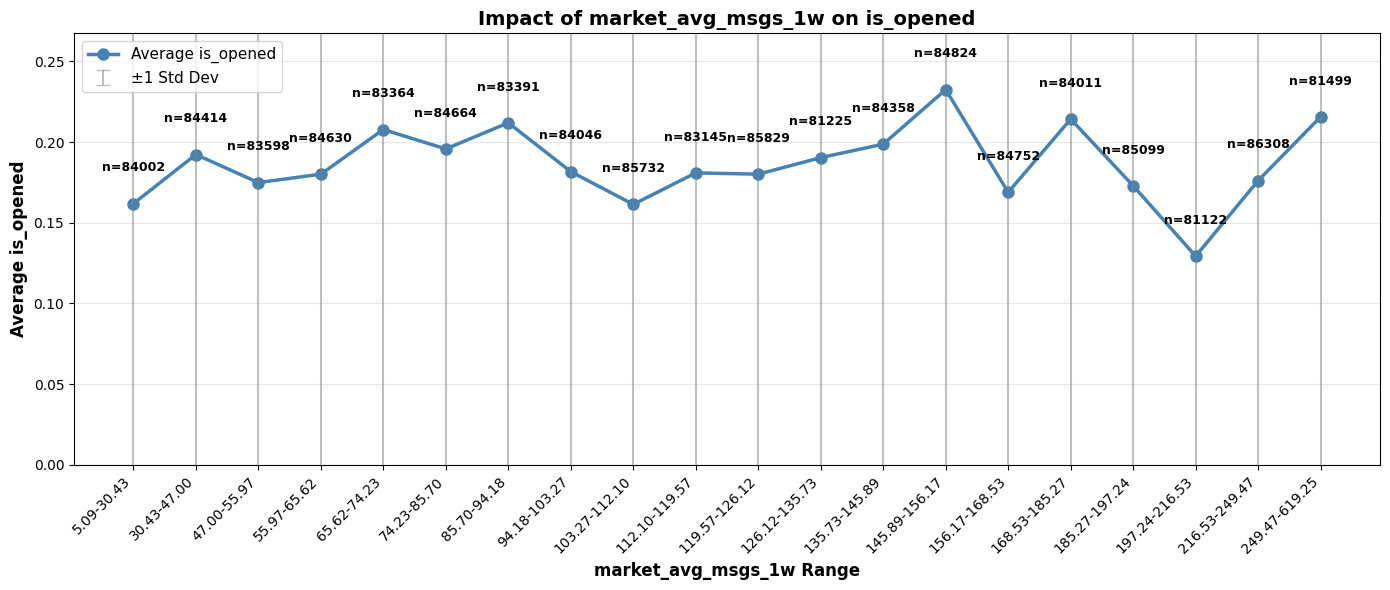

✅ Saved: sent_count_bar_plot.png


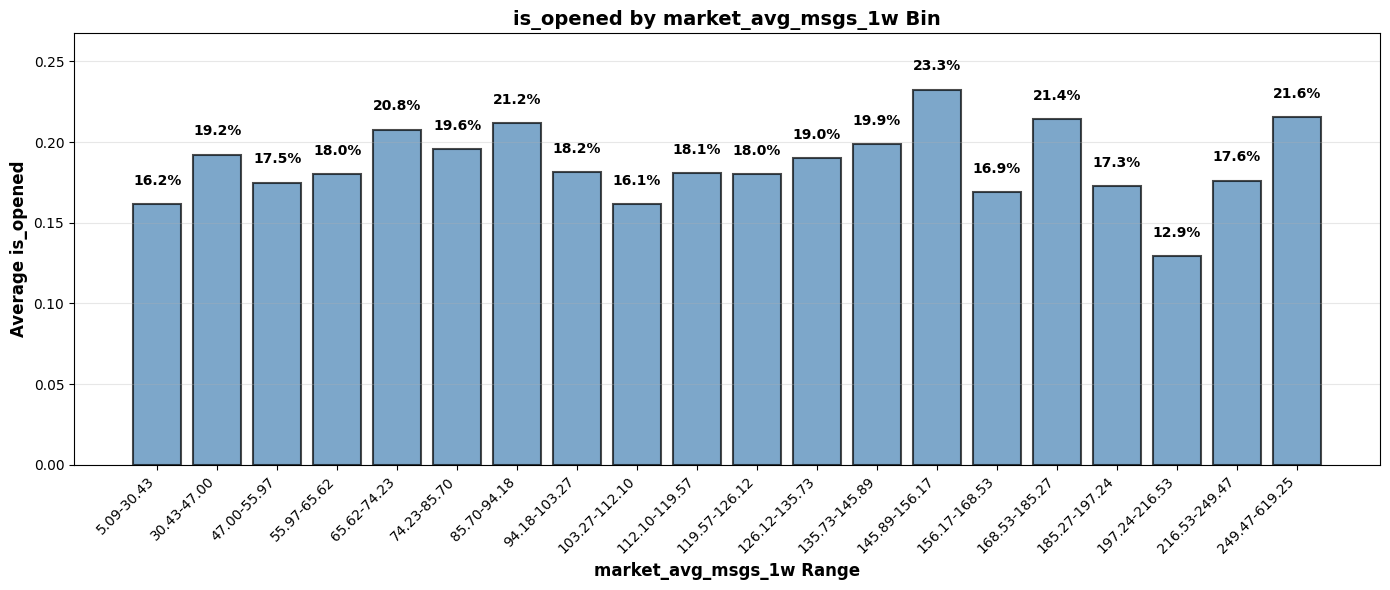

✅ Saved: sent_count_box_plot.png


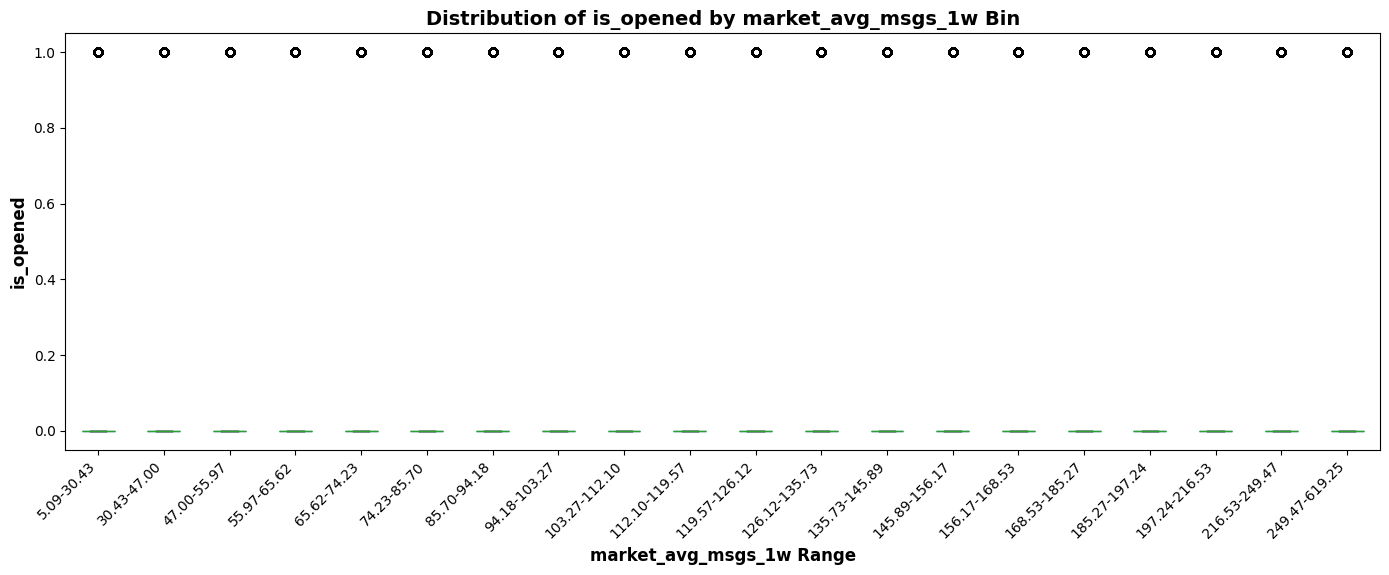


KEY INSIGHTS
Lowest bin average is_opened: 16.2%
Highest bin average is_opened: 21.6%
Difference: 5.4%
Improvement factor: 1.33x
Total bins created: 20



In [57]:
# Example usage 2: Analyze sent_count_1m vs is_opened
print("\n\nEXAMPLE 2: Message Count vs Open Status")
binned_analysis_2 = plot_binned_analysis(
    df, 
    bin_col='market_avg_msgs_1w',
    agg_col='is_opened',
    num_quantiles=20,
    agg_func='mean',
    save_prefix='sent_count_'
)

### Logistic Regression

In [218]:
import pandas as pd

# Ensure sent_at is in datetime format
df['sent_at'] = pd.to_datetime(df['sent_at'])

# Find the earliest date in the dataset
start_date = df['sent_at'].min()

# Define cutoff date (30 days after the earliest date)
cutoff_date = start_date + pd.Timedelta(days=30)

start_date, cutoff_date

(Timestamp('2021-04-30 07:22:39'), Timestamp('2021-05-30 07:22:39'))

In [219]:
# Keep only rows after the cutoff date
df = df[df['sent_at'] > cutoff_date]

In [223]:
df['sent_count_1m'] = df['sent_count_1m'].fillna(0)
df['sent_count_1w'] = df['sent_count_1w'].fillna(0)

/var/folders/bg/38ht234d5p50ytp9mrxf80nc0000gn/T/ipykernel_76482/2100988221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sent_count_1m'] = df['sent_count_1m'].fillna(0)
/var/folders/bg/38ht234d5p50ytp9mrxf80nc0000gn/T/ipykernel_76482/2100988221.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sent_count_1w'] = df['sent_count_1w'].fillna(0)


In [227]:
df['is_opened_rate_1w'] = df['is_opened_rate_1w'].fillna(0)

/var/folders/bg/38ht234d5p50ytp9mrxf80nc0000gn/T/ipykernel_76482/660696632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['is_opened_rate_1w'] = df['is_opened_rate_1w'].fillna(0)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
import statsmodels.api as sm

# ================================================================
# 1. HELPER FUNCTIONS
# ================================================================

def safe_div(a, b):
    """Avoid division by zero."""
    return a / b if b not in [0, None, np.nan] else 0

# ================================================================
# 2. CREATE FATIGUE FEATURES
# ================================================================

def build_fatigue_features(df):

    df = df.copy()

    df["weekly_to_monthly_msgs_ratio"] = df.apply(
        lambda r: safe_div(r["sent_count_1w"], r["sent_count_1m"] / 4 if r["sent_count_1m"] > 0 else 0),
        axis=1
    )

    df["weekly_and_monthly_msgs_diff"] = df["sent_count_1w"] - df["sent_count_1m"] / 4

    df["weekly_to_monthly_avg_market_msgs"] = df["market_avg_msgs_1w"] - df["market_avg_msgs_1m"]

    df["expected_open_rate"] = (
        0.7 * df["is_opened_rate_prev_smooth"].fillna(0) +
        0.3 * df["global_is_opened_rate_1w"].clip(0, 1).fillna(0)
    )

    df["weekly_and_expected_open_rate_diff"] = df["is_opened_rate_1w"].fillna(0) - df["expected_open_rate"]

    df["weekly_and_monthly_open_rate_diff"] = (
        df["is_opened_rate_1w"].fillna(0) -
        df["is_opened_rate_1m"].fillna(0)
    )

    return df

In [266]:
df_f = build_fatigue_features(df)

In [278]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

def build_fatigue_effect_model_statsmodels(df):
    """
    Build fatigue effect model using statsmodels with standardized features.
    Returns a summary table with rounded coefficients, std errors, z-values, and p-values.
    """
    # Filter rows where sent_count_1d > 0
    df = df[df["sent_count_1d"] > 0].copy()

    features = [
        "weekly_to_monthly_msgs_ratio",
        "weekly_and_monthly_msgs_diff",
        "weekly_to_monthly_avg_market_msgs",
        "is_opened_rate_prev_smooth",
        "is_opened_rate_1w",
        "weekly_and_expected_open_rate_diff",
        "weekly_and_monthly_open_rate_diff",
    ]

    # Drop rows with nulls in features or target
    df_model = df[features + ["is_opened"]].dropna()

    X = df_model[features]
    y = df_model["is_opened"]

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)

    # Add intercept
    X_scaled = sm.add_constant(X_scaled)

    # Train-test split for evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Fit logistic regression with standardized features
    logit_model = sm.Logit(y_train, X_train)
    result = logit_model.fit(disp=False)

    # Predict on test set
    y_prob = result.predict(X_test)
    y_pred = (y_prob >= 0.5).astype(int)

    # Evaluation
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    # Summary table with rounded values
    summary_df = pd.DataFrame({
        "feature": result.params.index,
        "coefficient": result.params.round(4),
        "std_err": result.bse.round(4),
        "z_value": result.tvalues.round(4),
        "p_value": result.pvalues.round(4)
    }).sort_values("p_value")

    print("\n--- FATIGUE EFFECT MODEL (Statsmodels, Standardized Features) ---")
    print(f"ROC-AUC: {auc:.4f}")
    print(f"Accuracy: {acc:.4f}\n")
    print(summary_df)

    return result, summary_df, scaler


def plot_summary_table(summary_df):
    """
    Plot the summary table with rounded values.
    """
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.axis('tight')
    ax.axis('off')

    table_data = summary_df.values
    col_labels = summary_df.columns

    table = ax.table(cellText=table_data,
                     colLabels=col_labels,
                     loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)

    plt.show()



--- FATIGUE EFFECT MODEL (Statsmodels, Standardized Features) ---
ROC-AUC: 0.9149
Accuracy: 0.8553

                                                               feature  \
const                                                            const   
weekly_to_monthly_msgs_ratio              weekly_to_monthly_msgs_ratio   
weekly_to_monthly_avg_market_msgs    weekly_to_monthly_avg_market_msgs   
is_opened_rate_1w                                    is_opened_rate_1w   
weekly_and_expected_open_rate_diff  weekly_and_expected_open_rate_diff   
weekly_and_monthly_open_rate_diff    weekly_and_monthly_open_rate_diff   
weekly_and_monthly_msgs_diff              weekly_and_monthly_msgs_diff   
is_opened_rate_prev_smooth                  is_opened_rate_prev_smooth   

                                    coefficient  std_err   z_value  p_value  
const                                   -1.4132   0.0078 -180.5191   0.0000  
weekly_to_monthly_msgs_ratio             0.1991   0.0095   21.0639   0.0000 

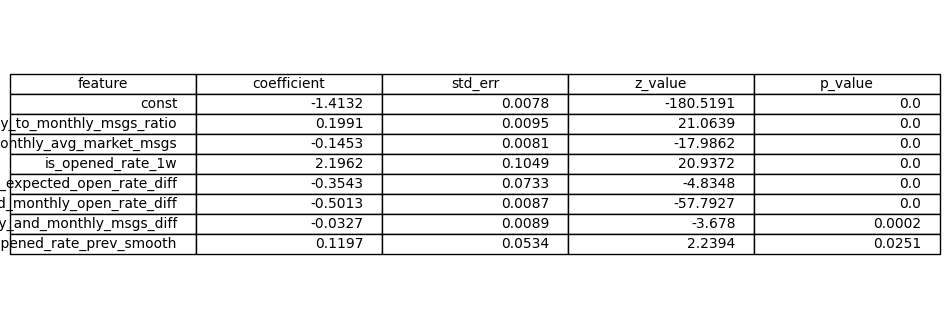

In [279]:
result, summary_df, scaler = build_fatigue_effect_model_statsmodels(df_f)
plot_summary_table(summary_df)

In [311]:
def plot_feature_curves(result, df, features, scaler):
    """
    Plot partial dependence curves for each feature in subplots.
    X-axis: true feature values (original scale)
    Y-axis: predicted probability of opening (fixed range 0–1)
    """
    import numpy as np
    import math
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    # Standardized features (same as model input)
    X_scaled = scaler.transform(df[features])
    X_scaled = pd.DataFrame(X_scaled, columns=features, index=df.index)
    X_scaled = sm.add_constant(X_scaled)

    n_features = len(features)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        ax = axes[i]

        # Range in standardized space
        x_range_std = np.linspace(X_scaled[feature].min(), X_scaled[feature].max(), 100)

        # Convert back to original scale manually
        feature_idx = features.index(feature)
        x_range_orig = x_range_std * scaler.scale_[feature_idx] + scaler.mean_[feature_idx]

        # Build dataset: others at mean
        X_temp = X_scaled.mean().to_dict()
        preds = []
        for val in x_range_std:
            X_temp[feature] = val
            X_row = pd.DataFrame([X_temp], columns=X_scaled.columns)
            preds.append(result.predict(X_row)[0])  # probability

        # Plot curve
        ax.plot(x_range_orig, preds, color="blue")
        ax.set_xlabel(f"{feature} (original scale)")
        ax.set_ylabel("Predicted open probability")
        ax.set_title(f"Effect of {feature}")
        ax.set_ylim(0, 1)  # force y-axis to probability range
        ax.grid(True)

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

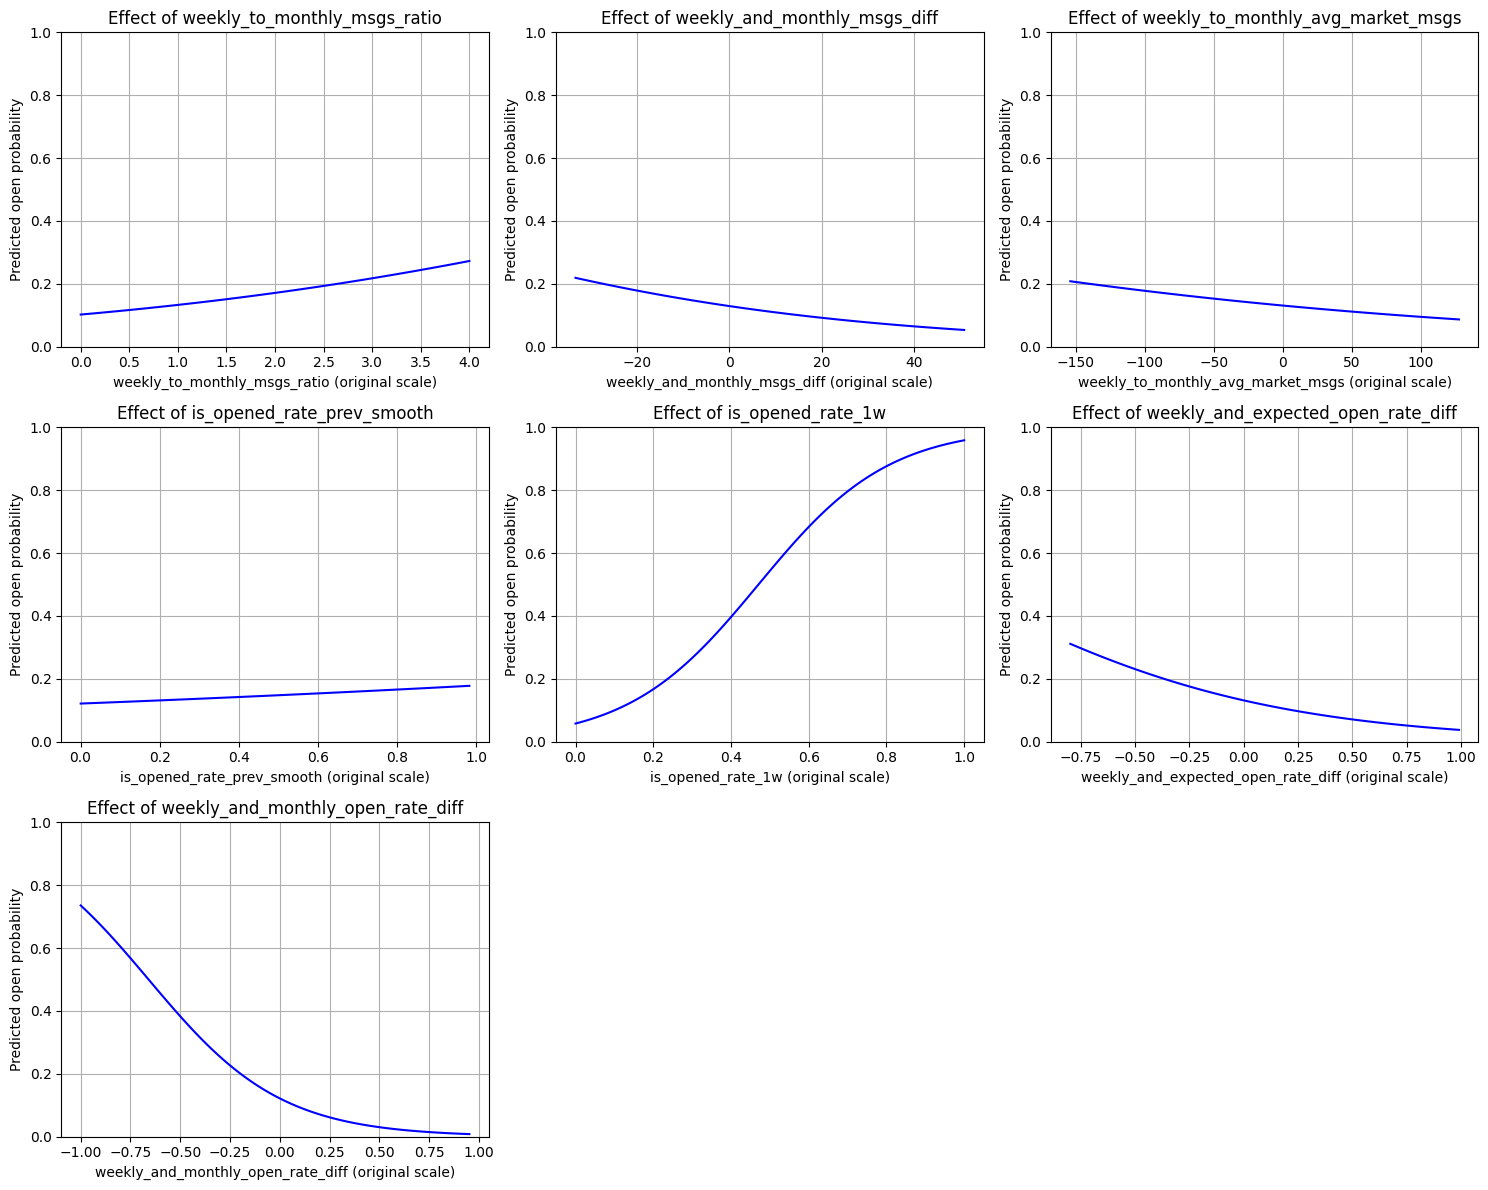

In [312]:
features = [
    "weekly_to_monthly_msgs_ratio",
    "weekly_and_monthly_msgs_diff",
    "weekly_to_monthly_avg_market_msgs",
    "is_opened_rate_prev_smooth",
    "is_opened_rate_1w",
    "weekly_and_expected_open_rate_diff",
    "weekly_and_monthly_open_rate_diff",
]

plot_feature_curves(result, df_f, features, scaler)

### Generalized Additive Model

In [295]:
# Generalized Additive Model (GAM) with cubic splines and L2 regularization
# Requires: pip install pygam

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from pygam import LogisticGAM, s


def build_fatigue_effect_gam(df):
    """
    Build a GAM with cubic spline terms and L2 regularization to predict is_opened.
    Returns the fitted GAM model and the feature list.
    """
    # Filter and define features
    df = df[df["sent_count_1d"] > 0].copy()

    features = [
        "weekly_to_monthly_msgs_ratio",
        "weekly_and_monthly_msgs_diff",
        "weekly_to_monthly_avg_market_msgs",
        "is_opened_rate_prev_smooth",
        "is_opened_rate_1w",
        "weekly_and_expected_open_rate_diff",
        "weekly_and_monthly_open_rate_diff",
    ]

    # Drop rows with nulls in features or target
    df_model = df[features + ["is_opened"]].dropna()
    X = df_model[features].values
    y = df_model["is_opened"].values

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Define GAM: cubic splines (default for s()) with L2 regularization via lam
    # You can tune n_splines and lam; start with reasonable defaults
    gam = LogisticGAM(
        s(0, n_splines=20) +
        s(1, n_splines=20) +
        s(2, n_splines=20) +
        s(3, n_splines=20) +
        s(4, n_splines=20) +
        s(5, n_splines=20) +
        s(6, n_splines=20),
        lam=0.6
    )

    # Fit with grid search over lam to improve performance (optional but helpful)
    # Comment out if you prefer fixed lam above
    try:
        gam.gridsearch(X_train, y_train, lam=np.logspace(-2, 1, 10))
    except Exception:
        # Fallback to simple fit if gridsearch fails
        gam.fit(X_train, y_train)

    # Evaluate
    y_prob = gam.predict_proba(X_test)
    y_pred = (y_prob >= 0.5).astype(int)

    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)

    print("\n--- FATIGUE EFFECT GAM (Cubic Splines + L2 Regularization) ---")
    print(f"ROC-AUC: {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")

    return gam, features


def plot_gam_pdp_subplots(gam, df, features, n_cols=3, n_points=200):
    """
    Plot partial dependence curves (PDPs) for each feature in subplots.
    X-axis: true feature values (original scale)
    Y-axis: predicted open probability (from GAM)
    """
    import math

    # Prepare grid for subplots
    n_features = len(features)
    n_rows = math.ceil(n_features / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = np.array(axes).reshape(-1)  # flatten

    # Use the data range for each feature to build PDPs
    X = df[features].dropna().values

    for i, feature in enumerate(features):
        ax = axes[i]

        # Build a grid over the feature's observed range
        x_min = np.nanmin(X[:, i])
        x_max = np.nanmax(X[:, i])
        grid = np.linspace(x_min, x_max, n_points)

        # Partial dependence using pygam: returns (pdp, confidence intervals)
        pdp, lower, upper = gam.partial_dependence(term=i, X=grid, width=0.95)

        # Plot the PDP as predicted probability (LogisticGAM returns on link scale if requested;
        # here pygam's partial_dependence for LogisticGAM gives probabilities by default)
        ax.plot(grid, pdp, color="blue", lw=2)
        ax.fill_between(grid, lower, upper, color="blue", alpha=0.15, label="95% CI")

        ax.set_title(f"Partial dependence: {feature}")
        ax.set_xlabel(f"{feature} (original scale)")
        ax.set_ylabel("Predicted open probability")
        ax.grid(True)

    # Hide unused axes if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:

# Example usage:
gam, features = build_fatigue_effect_gam(df_f)

In [308]:
def plot_gam_pdp_subplots(gam, df, features, n_cols=3, n_points=200):
    """
    Plot partial dependence curves (PDPs) for each feature in subplots.
    X-axis: true feature values (original scale)
    Y-axis: predicted open probability (0–1)
    """
    import numpy as np
    import math
    import matplotlib.pyplot as plt

    n_features = len(features)
    n_rows = math.ceil(n_features / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = np.array(axes).reshape(-1)

    X_data = df[features].dropna().values
    mean_vals = X_data.mean(axis=0)

    for i, feature in enumerate(features):
        ax = axes[i]

        # Range over observed values
        x_min = np.nanmin(X_data[:, i])
        x_max = np.nanmax(X_data[:, i])
        grid = np.linspace(x_min, x_max, n_points)

        # Construct full X matrix: others fixed at mean
        X_grid = np.tile(mean_vals, (n_points, 1))
        X_grid[:, i] = grid

        # Partial dependence (log-odds)
        pdp, confi = gam.partial_dependence(term=i, X=X_grid, width=0.95)

        # Convert log-odds to probabilities using sigmoid
        sigmoid = lambda z: 1 / (1 + np.exp(-z))
        pdp_prob = sigmoid(pdp)
        confi_prob = sigmoid(confi)

        # Plot PDP with confidence interval
        ax.plot(grid, pdp_prob, color="blue", lw=2)
        ax.fill_between(grid, confi_prob[:, 0], confi_prob[:, 1], color="blue", alpha=0.15)

        ax.set_title(f"Partial dependence: {feature}")
        ax.set_xlabel(f"{feature} (original scale)")
        ax.set_ylabel("Predicted open probability")
        ax.set_ylim(0, 1)  # force y-axis to probability range
        ax.grid(True)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

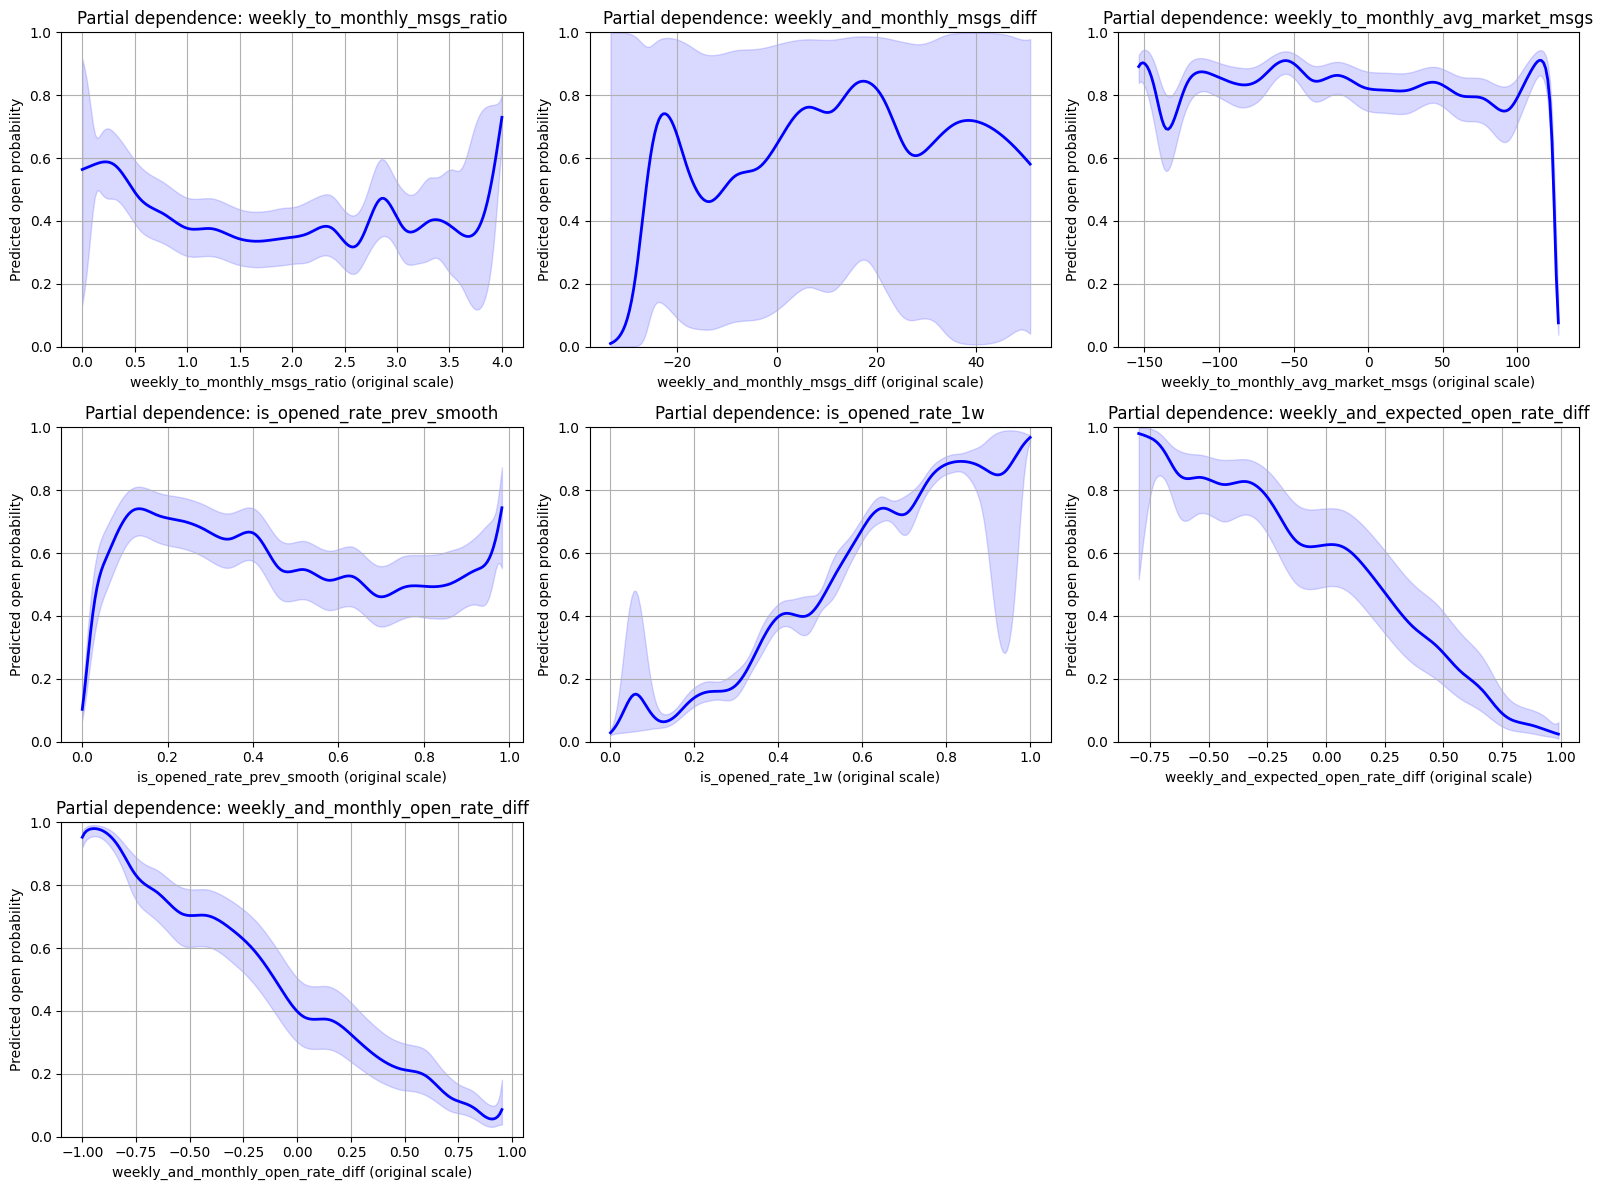

In [309]:
plot_gam_pdp_subplots(gam, df_f, features, n_cols=3, n_points=200)